# DESI Image Validation over Repeated observations DR8

Version of Dec nd 2019 (from July 8th 2018 DR7)


Version by E.Gaztanaga on 26th  Feb 2018
This is written in Python3, but it also works with Python2.7


Does some basic validation plots over COSMOS subsets prepare by Dustin (see below).  The goal is to test if the flux errors produce by tractor are consistent with repeated measurements for the same objects. We match objects in (RA,DEC) with 1 arsec (after removing any possible merger within 1 arcsec (matched_size in general)). The match is done using pandas.merge over integers but we have checked that this yields the same result as matching to the nearest neighbours.

From Dustin (e-mail of 19-7-2017)

I have defined an expanded set of COSMOS subsets using approximately the pipeline settings we expect to use for DR5.  This includes the REX models with approximately the PSF/REX model selection cuts defined by Christophe.

There are 10 subsets, each with exactly 3x each of g,r,z exposures.  They are all supposed to have noise added to bring them to the DESI imaging requirements depth (g=24.0, r=23.4, z=22.5) for galaxy profiles.  Subset #60 has the best-seeing data, and subset #69 the worst, in this set.  But even #69 is not too bad.
#60 has g ~ 1.1", r ~ 1.2", z ~ 1.0",
#64 has g ~ 1.3", r ~ 1.3", z ~ 1.25", and
#69 has g ~ 1.8", r ~ 1.9", z ~ 1.7".

One note: here I'm *not* correcting for the small amount of dust in the COSMOS region -- so while the imaging requirements are for extinction-corrected mags, these depths have no extinction correction.  Extinction in COSMOS is about g=0.06, r=0.04, z=0.02 mag.

Tractor catalogs for all these are available on the web here:

http://portal.nersc.gov/project/cosmo/temp/dstn/cosmos-subsets/cosmos-dr5-60-cats.tgz
through
http://portal.nersc.gov/project/cosmo/temp/dstn/cosmos-subsets/cosmos-dr5-69-cats.tgz


# DR8

On Wed, Sep 18, 2019 at 5:13 PM Rongpu Zhou <rongpu.zhou@pitt.edu> wrote:
Hi Enrique, Marc,

The DR8 COSMOS repeats are now available: /global/cscratch1/sd/desiproc/dr8-cosmos

I've also asked Martin to produce sweep catalogs (if you prefer to work with those instead of the full tractor catalogs), and they should be available soon. I haven't looked at the data yet –– I'll probably do it during/after the Tucson imaging workshop next week.

Best,
Rongpu



In [6]:
%matplotlib notebook    

from sqlalchemy import Integer, Column, create_engine, ForeignKey, Sequence, String, Enum, Float, Index
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
import numpy as np
import pandas as pd
#from pandas.core import datetools
#from pandas import read_sql
import scipy.stats as st

import matplotlib
import matplotlib.pyplot as plt

import os
import random
from scipy.optimize import curve_fit as cu
import astropy.io.fits as fits
import glob
import os
from os.path import join
import sys
import statsmodels.api as sm
import scipy.stats as st
from scipy.spatial import KDTree
from scipy.optimize import curve_fit as cu
from astropy.table import Table

### Some definitions

In [13]:
# some defitions

def sigma_68(arr, axis=None):
    """Input: an (multi-dimensional) array
    Optional input: the axis along which to calculate the metric
    Outputs: the 68% spread of data about the median value of the array
    """
    upper, lower = np.percentile(arr, [84.075, 15.825], axis=axis)
    return (upper - lower) / 2.0

def draw_histdf(dir,CX,CC,df,C1,df1,C2,df2,C3,df3,filename):
    plt.rcParams['agg.path.chunksize'] = 10000
    num_bins= 30
    gfun = lambda x, m0, s0 : st.norm.pdf(x,loc=m0,scale=s0)
    number_All=len(df)
    df=df[np.abs(df)<df_cut]
    df1=df1[np.abs(df1)<df_cut]
    df2=df2[np.abs(df2)<df_cut]
    df3=df3[np.abs(df3)<df_cut]    
    #print "all pairs:",  number_All
    plt.clf()
    n, bins, patches = plt.hist(df,num_bins,label=CC+" $\sigma_{68}$="+str(np.round(sigma_68(df),3)),
                                histtype='step',color='r',alpha=0.5,normed=True,lw=2)
    n, bins, patches = plt.hist(df1,num_bins,label=C1+" $\sigma_{68}$="+str(np.round(sigma_68(df1),3)),
                                histtype='step',color='g',alpha=0.5,normed=True,lw=2)
    n, bins, patches = plt.hist(df2,num_bins,label=C2+" $\sigma_{68}$="+str(np.round(sigma_68(df2),3)),
                                histtype='step',color='m',alpha=0.5,normed=True,lw=2)    
    n, bins, patches = plt.hist(df3,num_bins,label=C3+" $\sigma_{68}$="+str(np.round(sigma_68(df3),3)),
                                histtype='step',color='b',alpha=0.5,normed=True,lw=2)        

    # add a 'best fit' line
    bin_cent=(bins[1:]+bins[:-1])/2.
    nnn=n/np.sum(n)/(bins[1]-bins[0])     # normalized
    bin_peak=bin_cent[abs(bin_cent)<2]
    nnn2=nnn[abs(bin_cent)<2]
    Gaussian_fit = cu(gfun,bin_cent,nnn,p0=(0,1))
    print(Gaussian_fit[0])
    gfit=st.norm.pdf(bin_cent,loc=Gaussian_fit[0][0],scale=Gaussian_fit[0][1])
    gfit=gfit*np.sum(n)/np.sum(gfit) # normalized
    y0 = st.norm.pdf(bin_cent,0., 1)
    y0 = y0*np.sum(n)/np.sum(y0)  # normalized
    y = st.norm.pdf(bin_cent, np.average(df), sigma_68(df))
    y = y*np.sum(n)/np.sum(y)  # normalized
    y1 = st.norm.pdf(bin_cent,np.average(df1), sigma_68(df1))
    y1 = y1*np.sum(n)/np.sum(y1) # normalized
    y2 = st.norm.pdf(bin_cent,np.average(df2), sigma_68(df2))
    y2 = y2*np.sum(n)/np.sum(y2) # normalized    
    y3 = st.norm.pdf(bin_cent,np.average(df3), sigma_68(df3))
    y3 = y3*np.sum(n)/np.sum(y3) # normalized        
    ymax=np.max(y0)
    xmin=-4.8    
    #plt.hist(df,bins=100)
    plt.plot(bin_cent, y,c="r",lw=2)
    plt.plot(bin_cent, y1,c="g",lw=2)
    plt.plot(bin_cent, y2,c="m",lw=2)
    plt.plot(bin_cent, y3,c="b",lw=2)    
    plt.plot(bin_cent, y0,"k--",lw=2,label=" Expected  $\sigma_{68}$=1")
    gp = plt.legend(loc=1, fontsize=10)
    gp.set_frame_on(False)
    plt.xlim((-df_cut,df_cut))
    plt.xlabel(CX+"[<"+CC+">="+str(np.median(df))+"]")
    plt.text(xmin,ymax*.95,CC+" #= "+str(np.round(len(df),0)),fontsize=10)
    plt.text(xmin,ymax*.9,C1+" #= "+str(np.round(len(df1),0)),fontsize=10)
    plt.text(xmin,ymax*.85,C2+" #= "+str(np.round(len(df2),0)),fontsize=10) 
    plt.text(xmin,ymax*.8,C3+" #= "+str(np.round(len(df3),0)),fontsize=10)     
    plt.text(xmin,ymax*.75,"   "+CC+" :")
    plt.text(xmin,ymax*.7," |df|>"+str(df_cut)+"="+str(np.round(100.*(1.-len(df)/number_All),1))+"%",fontsize=10)    
    plt.text(xmin,ymax*.65," <Flux>="+str(np.round(mean_f,2))+"+-"+str(np.round(std_f,2)),fontsize=10)
    plt.text(xmin,ymax*.6," <S/N>="+str(np.round(s2n,2)),fontsize=10)
    plt.text(xmin,ymax*.55," <shape_r>="+str(np.round(mean_r50,2))+"+-"+str(np.round(std_r50,2)),fontsize=10)    
    plt.text(xmin,ymax*.5," <psf>="+str(np.round(mean_psf,2))+"+-"+str(np.round(std_psf,2)),fontsize=10)
    #plt.text(xmin,ymax*.5," <$\Delta$(psf)>="+str(np.round(mean_dpsf,2)),fontsize=10)
    #plt.text(1.1,ymax*.90,"histogram $\sigma_{68}$(df)="+str(np.round(sigma_68(df),3)),fontsize=12,color="r")
    #plt.text(1.1,ymax*.85,"Gauss fit df<2 $\sigma$="+str(np.round(Gaussian_fit[0][1],3)),fontsize=12,color="m")
    #plt.text(1.1,ymax*.8,"Expected $\sigma$=1",fontsize=12,color="k")
    #plt.title(str(m1)+"<mag<"+str(m2)+" |df|< "+str(df_cut)+ " fracmasked < "+str(frac))
    plt.title(str(m1)+"<mag<"+str(m2)+" |df|< "+str(df_cut)) #+"  median mag dif. "+CC+"= "+str(np.median(dmagALL)))


    plt.show()
    plt.savefig(dir+"/df-"+CC+filename+".png")
    plt.close()    
    return


def draw2_sigma68(dir,Cdf,df,CX,X,CY,Y,filename,ymin,ymax):
    plt.rcParams['agg.path.chunksize'] = 10000
    meanY=np.median(Y)
    num_bins = 20
    n, bins, patches = plt.hist(X, 'sturges')   
    mean_bin=(bins[1:]+bins[:-1])/2.  # geometrical mean
    std_df=mean_bin*0
    median_df=mean_bin*0
    mean_bin1=(bins[1:]+bins[:-1])/2.  # geometrical mean
    std_df1=mean_bin*0
    mean_bin2=(bins[1:]+bins[:-1])/2.  # geometrical mean
    std_df2=mean_bin*0
    for i1 in range(len(bins)-1):
        bin1=bins[i1]
        bin2=bins[i1 + 1]
        sel = (X>bin1) & (X<bin2) 
        sel1 = (X>bin1) & (X<bin2) & (Y<meanY)
        sel2 = (X>bin1) & (X<bin2) & (Y>meanY)
        if (len(X[sel])>0):
            mean_bin[i1]=sum(X[sel])/len(X[sel])  # true bin
            std_df[i1]=sigma_68(df[sel])
            median_df[i1]=np.median(df[sel])            
        if (len(X[sel1])>0):
            mean_bin1[i1]=sum(X[sel1])/len(X[sel1])  # true bin
            std_df1[i1]=sigma_68(df[sel1])
        if (len(X[sel2])>0):
            mean_bin2[i1]=sum(X[sel2])/len(X[sel2])  # true bin
            std_df2[i1]=sigma_68(df[sel2])            
    plt.clf()
    plt.hexbin(X,(df),gridsize=40,mincnt=1)

    #plt.hist(df,bins=100,normed=True)
    plt.plot(mean_bin,median_df, 'k--', lw=3, label="mendian")
    #plt.plot(mean_bin,mean_bin*0+1, 'w--', lw=3, label="Expected $\sigma_{68}(df)$=1")    
    plt.plot(mean_bin,std_df, 'r', lw=3, label="$\sigma_{68}(df)$ for All")
    plt.plot(mean_bin1,std_df1, 'y--', lw=3, label="$\sigma_{68}(df)$ for "+CY+"<"+str(np.round(meanY,3))) 
    plt.plot(mean_bin2,std_df2, 'c--', lw=3, label="$\sigma_{68}(df)$ for "+CY+">"+str(np.round(meanY,3)))     

    plt.xlabel(CX)
    plt.ylabel(Cdf)
    plt.ylim((ymin,ymax))
    plt.title(filename)

    gp = plt.legend(loc=6, fontsize=12)
    gp.set_frame_on(False)

    leg = plt.legend(framealpha = 0, loc = 3, fontsize=13)
    for text in leg.get_texts():
        plt.setp(text, color = 'orange')
    plt.grid()
    plt.show()
    plt.savefig(dir+"/dfvs"+CX+CY+filename+".png")
    plt.close() 
    return



def plot_hist(dir,filename,CX,X,LogTrue):
    #plt.clf()
    nnn, bins, patches = plt.hist(X,'sturges',log=True)
    p50=np.percentile(X,50)
    p68=np.percentile(X,68)
    p95=np.percentile(X,95)
    p99=np.percentile(X,99.5)
    p1=np.percentile(X,0.5)    
    plt.plot(nnn*0+p50,nnn,label="50%="+str(np.round(p50,2)))
    plt.plot(nnn*0+p68,nnn,label="68%="+str(np.round(p68,2)))
    plt.plot(nnn*0+p95,nnn,label="95%="+str(np.round(p95,2)))
    if (LogTrue):
        plt.xscale('log')
    else:
        plt.xscale('linear')
    plt.yscale('log')        
    gp = plt.legend(loc=0, fontsize=12)
    gp.set_frame_on(False)
    plt.xlim(p1,p99)
    plt.xlabel(CX)
    plt.show()  
    plt.title("0.5-99.5 percentils")
    plt.savefig(dir+"/"+CX+"-"+filename+".png") 
    plt.close()
    print('Inside plot_hist')
    return

def plot_Brickvalues(dir,filename,Cdf,df,x1,y1):                 
    nbin=60  
    iscale=int(3600/nbin)
    ccdmap= np.zeros((iscale,iscale))    # image with variance
    nccdmap= np.zeros((iscale,iscale))   # image with number of pairs

    for i in np.arange(len(df)):
        x=np.int(x1[i]/nbin)
        y=np.int(y1[i]/nbin)           
        ccdmap[x,y]=ccdmap[x,y]+df[i]       
        nccdmap[x,y]=nccdmap[x,y]+1
    mean_nccdmap=np.mean(nccdmap[nccdmap!=0])    
    nccdmap[nccdmap==0]=-1
    ccdmap=ccdmap/nccdmap
    mean_ccdmap=np.mean(ccdmap[nccdmap>0])
    max_ccdmap=np.max(ccdmap[nccdmap>0])
    min_ccdmap=np.min(ccdmap[nccdmap>0])    
    plt.figure()
    plt.imshow(ccdmap,vmin=min_ccdmap,vmax=max_ccdmap,cmap='jet',origin='lower')
    plt.colorbar()
    plt.title('<'+Cdf+'>='+str(np.round(mean_ccdmap,2)))
    plt.xlabel("y / "+str(nbin))
    plt.ylabel("x / "+str(nbin))
    plt.grid()
    plt.savefig(dir+"/BRICKmap-"+Cdf+filename+".png")
    plt.clf()
    plt.figure()
    plt.imshow(nccdmap,vmin=mean_nccdmap/2,vmax=mean_nccdmap*2,cmap='jet',origin='lower')  
    plt.colorbar()
    plt.title("<nObjects>="+str(np.round(mean_nccdmap,2)))
    plt.xlabel("y / "+str(nbin))
    plt.ylabel("x / "+str(nbin))
    plt.grid()
    plt.savefig(dir+"/nBRICKmap-"+Cdf+filename+".png")
    plt.close()    
    plt.clf()
    return

def readTractor(dir,filename):
#table = Table.read('catalog-dr5-60.fits')
##pandas_df = table.to_pandas() # this does not work because some cols have more dimensions
##pandas_df
#table[table['type']=='COMP']
#table    
    hdu = fits.open(dir+"/"+filename)
    dat = hdu[1].data
    print ("All= ",len(dat['ra']))
    flux1=10.**(0.4*(22.5-m1))
    flux2=10.**(0.4*(22.5-m2))    
    print(flux1,'<Flux<',flux2)
    if (dir=="Vplots2" ):
        dat['flux_g']=1.+np.random.normal(size=len(dat))/np.sqrt(dat['flux_ivar_g'])   
    noJunk2 = ((dat['brick_primary']) & (dat['anymask_g']==0) & (dat['anymask_r']==0) & (dat['anymask_z']==0) 
            & (dat['flux_g']<flux1) & (dat['flux_g']>flux2)  #  m1<mag<m2   mag=22.5-2.5log10(Flux)
            & (dat['flux_r']<flux1) & (dat['flux_r']>flux2)  
            & (dat['flux_z']<flux1) & (dat['flux_z']>flux2)
            & (dat['flux_ivar_g']*(dat['flux_g'])**2>s2ncut*s2ncut)
            & (dat['flux_ivar_r']*(dat['flux_r'])**2>s2ncut*s2ncut)               
            & (dat['flux_ivar_z']*(dat['flux_z'])**2>s2ncut*s2ncut)   
            & (dat['nobs_g']>nobs_min)  & (dat['nobs_r']>nobs_min)  & (dat['nobs_z']>nobs_min)               
            & (dat['psfsize_g']>0.1)  & (dat['psfsize_r']>0.1)  & (dat['psfsize_z']>0.1)
            & (dat['fracmasked_g']>=0) & (dat['fracmasked_g']<=frac) 
            & (dat['fracmasked_r']>=0) & (dat['fracmasked_r']<=frac)                
            & (dat['fracmasked_z']>=0) & (dat['fracmasked_z']<=frac) 
            & (dat['galdepth_g']>=0) & (dat['galdepth_r']>=0) & (dat['galdepth_z']>=0)                
              )
    dat = dat[noJunk2]
    print ("Selected= ",len(dat['ra']))
    areaDR2 = (np.max(dat['ra'])-np.min(dat['ra']) )*( np.max(dat['dec'])-np.min(dat['dec']))*np.cos(np.pi*np.mean(dat['dec']) / 180. )
    print ("Area=",areaDR2)
    ra=np.rint(3600.*dat['ra']/matched_size) # in matched_size arsec integers
    dec=np.rint(3600.*dat['dec']/matched_size) # in matched_size1 arsec
    dr5=Table()
    dr5['ra']=ra
    dr5['dec']=dec
    dr5['type']=dat['type']
    dr5['bx']=dat['bx']
    dr5['by']=dat['by']
    dr5['mjd_min']=dat['mjd_min']
    dr5['mjd_max']=dat['mjd_max']
    dr5['flux_g']=dat['flux_g']
    dr5['flux_r']=dat['flux_r']
    dr5['flux_z']=dat['flux_z']
    dr5['flux_ivar_g']=dat['flux_ivar_g']
    dr5['flux_ivar_r']=dat['flux_ivar_r']
    dr5['flux_ivar_z']=dat['flux_ivar_z']
    dr5['nobs_g']=dat['nobs_g']
    dr5['nobs_r']=dat['nobs_r']
    dr5['nobs_z']=dat['nobs_z']
    dr5['fracmasked_g']=dat['fracmasked_g']
    dr5['fracmasked_r']=dat['fracmasked_r']
    dr5['fracmasked_z']=dat['fracmasked_z']
    dr5['psfsize_g']=dat['psfsize_g']
    dr5['psfsize_r']=dat['psfsize_r']
    dr5['psfsize_z']=dat['psfsize_z']
    dr5['galdepth_g']=dat['galdepth_g']
    dr5['galdepth_r']=dat['galdepth_r']
    dr5['galdepth_z']=dat['galdepth_z']
    dr5['psfdepth_g']=dat['psfdepth_g']
    dr5['psfdepth_r']=dat['psfdepth_r']
    dr5['psfdepth_z']=dat['psfdepth_z']
    dr5['shape_r']=dat['shapeexp_r']*(1.-dat['fracdev'])+dat['shapedev_r']*dat['fracdev']
    dr5pd= dr5.to_pandas()
    # Remove all Merges with same ra and dec 1 arsec (usually none)
    dup= dr5pd.duplicated(subset=["ra","dec"],keep=False) # mark all duplicates as True
    dr5pd=dr5pd[dup==False]  # keep only unique

    print ("Unique= ",len(dr5pd))
    return dr5pd

def merge_tables(TT, columns=None):
    assert(len(TT) > 0)
    if columns in [None, 'minimal', 'fillzero']:
        cols = set(TT[0].get_columns())
        types = {}
        if columns == 'fillzero':
            for c in cols:
                types[c] = TT[0].get(c).dtype
                #print('col', c, 'is', types[c])
                
        for T in TT[1:]:
            if columns == 'minimal':
                if len(cols.symmetric_difference(T.get_columns())):
                    cols = cols.intersection(T.get_columns())
                continue

            if columns == 'fillzero':
                newcols = set(T.get_columns()) - cols
                for c in newcols:
                    # Assume numpy arrays
                    types[c] = T.get(c).dtype
                    #print('col', c, 'is', types[c])
                cols = cols.union(T.get_columns())
                continue

            # They must have the same set of columns
            if len(cols.symmetric_difference(T.get_columns())):
                print('Tables to merge must have the same set of columns.')
                print('First table columns:', cols)
                print('Target table columns:', T.get_columns())
                print('Difference:', cols.symmetric_difference(T.get_columns()))
            assert(len(cols.symmetric_difference(T.get_columns())) == 0)
        cols = list(cols)

        # Reorder the columns to match their order in TT[0].
        ocols = []
        for c in TT[0].get_columns():
            if c in cols and not c in ocols:
                ocols.append(c)
        # (for fillzero) -- add the rest of the columns (not in TT[0])
        for c in cols:
            if not c in ocols:
                ocols.append(c)
        cols = ocols

    else:
        for i,T in enumerate(TT):
            # ensure they all have the requested columns
            if not set(columns).issubset(set(T.get_columns())):
                print('Each table to be merged must have the requested columns')
                print('Table', i, 'is missing columns:', set(columns)-set(T.get_columns()))
                print('columns', columns)
                print('T.columns', T.get_columns())
                assert(False)
        cols = columns
    N = sum([len(T) for T in TT])
    td = tabledata()

    for col in cols:
        if col.startswith('_'):
            continue

        if columns == 'fillzero':
            vv = []
            # Handle NxD(xEx...) arrays: find first extant array, record its shape
            v0 = None
            for T in TT:
                if col in T.get_columns():
                    v0 = T.get(col)
                    break
            shape = v0.shape[1:]

            for T in TT:
                if col in T.get_columns():
                    vv.append(T.get(col))
                else:
                    vv.append(np.zeros((len(T),)+shape, types[col]))
            V = np.concatenate(vv)
            td.set(col, V)
            continue

        v0 = TT[0].getcolumn(col)
        if isinstance(v0, np.ndarray):
            V = np.concatenate([T.getcolumn(col) for T in TT])
        elif type(v0) is list:
            V = v0
            for T in TT[1:]:
                V.extend(T.getcolumn(col))
        elif np.isscalar(v0):
            #print('merge_tables: copying scalar from first table:', col, '=', v0)
            V = v0
        else:
            raise RuntimeError("pyfits_utils.merge_tables: Don't know how to concatenate type: %s" % str(type(v0)))
            
        td.set(col, V)
    #td._columns = cols
    assert(td._length == N)
    return td
    
    



In [5]:
dir="/global/u1/m/manera/DESI/validation-outputs/Vplots-DR8half"

import astropy.io.fits as fits
#import astropy.cosmology as co
#c1 = co.Planck15
import numpy as n
import glob
import os
from os.path import join
import sys
import matplotlib.pyplot as p
from scipy.spatial import KDTree
import scipy.stats as st

def writeSummaryCat(N):
        outFile = "decam-sub"+N+".fits"
        #pattern = join("../duplicates/decam-sub"+N,"tractor*.fits")
        pattern = join("/global/cscratch1/sd/desiproc/dr8-cosmos/decam-sub"+N+"/tractor/*","tractor*.fits")
        print ('Reading files', pattern)
        tractorCatalogs = glob.glob(pattern)
        hdu = fits.open(tractorCatalogs[0])
        dat = hdu[1].data
        noJunk = (dat['brick_primary']) 
        out = dat[noJunk]
        #print (len(tractorCatalogs))

        #for jj in range(1,9,1):
        for jj in range(1,len(tractorCatalogs),1):            
            hduN = fits.open(tractorCatalogs[jj])
            dat = hduN[1].data
            noJunk = (dat['brick_primary'])
            out2=dat[noJunk]
            out = n.hstack((out,out2))
            #print ('out=',len(out))
        #print ('out=',len(out))                 

        tb_hdu = fits.BinTableHDU.from_columns(out)
        if os.path.isfile(outFile) :
                os.remove(outFile)
        tb_hdu.writeto(outFile)
        print ('Wrote', outFile,len(out))
        return len(tractorCatalogs)

#nn= writeSummaryCat("60")
#print nn
nn= writeSummaryCat("0")
print (nn)
nn= writeSummaryCat("1")
print (nn)
nn= writeSummaryCat("2")
print (nn)
nn= writeSummaryCat("3")
print (nn)
nn= writeSummaryCat("4")
print (nn)
nn= writeSummaryCat("5")
print (nn)
nn= writeSummaryCat("6")
print (nn)
nn= writeSummaryCat("7")
print (nn)
nn= writeSummaryCat("8")
print (nn)
nn= writeSummaryCat("9")
print (nn)

Reading files /global/cscratch1/sd/desiproc/dr8-cosmos/decam-sub0/tractor/*/tractor*.fits
Wrote decam-sub0.fits 171812
79
Reading files /global/cscratch1/sd/desiproc/dr8-cosmos/decam-sub1/tractor/*/tractor*.fits
Wrote decam-sub1.fits 170069
79
Reading files /global/cscratch1/sd/desiproc/dr8-cosmos/decam-sub2/tractor/*/tractor*.fits
Wrote decam-sub2.fits 153379
68
Reading files /global/cscratch1/sd/desiproc/dr8-cosmos/decam-sub3/tractor/*/tractor*.fits
Wrote decam-sub3.fits 160226
79
Reading files /global/cscratch1/sd/desiproc/dr8-cosmos/decam-sub4/tractor/*/tractor*.fits
Wrote decam-sub4.fits 150660
69
Reading files /global/cscratch1/sd/desiproc/dr8-cosmos/decam-sub5/tractor/*/tractor*.fits
Wrote decam-sub5.fits 153381
70
Reading files /global/cscratch1/sd/desiproc/dr8-cosmos/decam-sub6/tractor/*/tractor*.fits
Wrote decam-sub6.fits 167984
78
Reading files /global/cscratch1/sd/desiproc/dr8-cosmos/decam-sub7/tractor/*/tractor*.fits
Wrote decam-sub7.fits 146820
68
Reading files /global/cs

### **** ATENTION EDIT YOUR OWN DIR !!! ***

In [11]:
dir="/global/u1/m/manera/DESI/validation-outputs/Vplots-DR8half/"

All=  171812
63.09573444801933 <Flux< 0.25118864315095796
Selected=  15923
Area= 2.1462759170516135
Unique=  15921
All=  170069
63.09573444801933 <Flux< 0.25118864315095796
Selected=  19725
Area= 2.0854578849847756
Unique=  19723
All=  153379
63.09573444801933 <Flux< 0.25118864315095796
Selected=  42299
Area= 4.0576183817764555
Unique=  42293
All=  160226
63.09573444801933 <Flux< 0.25118864315095796
Selected=  19315
Area= 2.144090792275241
Unique=  19315
All=  150660
63.09573444801933 <Flux< 0.25118864315095796
Selected=  44926
Area= 4.028761529410304
Unique=  44922
All=  153381
63.09573444801933 <Flux< 0.25118864315095796
Selected=  35852
Area= 3.4420678607561146
Unique=  35850
All=  167984
63.09573444801933 <Flux< 0.25118864315095796
Selected=  12830
Area= 1.6762579594133125
Unique=  12828
All=  146820
63.09573444801933 <Flux< 0.25118864315095796
Selected=  41309
Area= 4.073732388498437
Unique=  41309
All=  148809
63.09573444801933 <Flux< 0.25118864315095796
Selected=  36342
Area= 3.

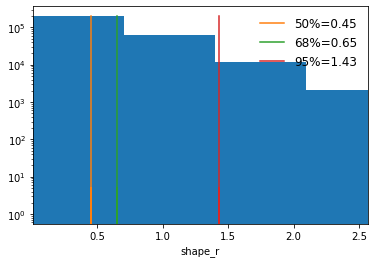

Inside plot_hist


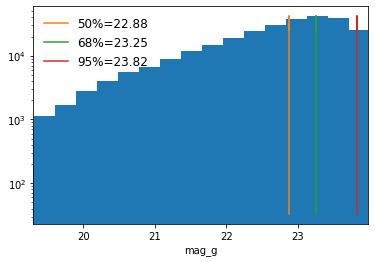

Inside plot_hist


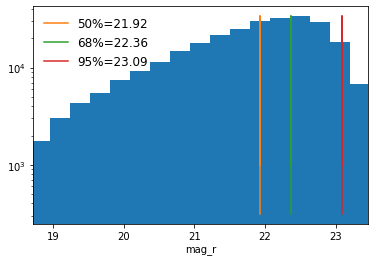

Inside plot_hist


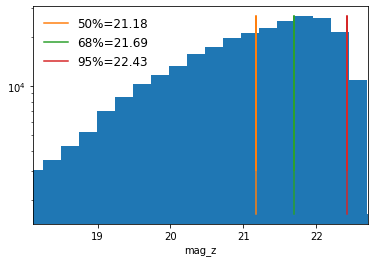

Inside plot_hist


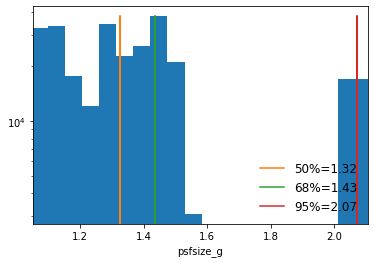

Inside plot_hist


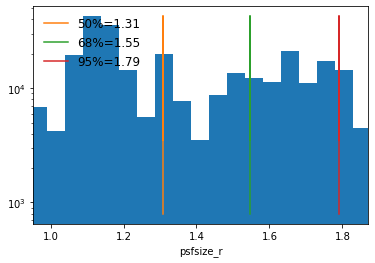

Inside plot_hist


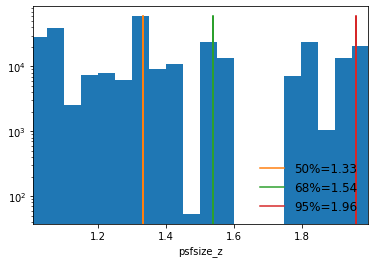

Inside plot_hist


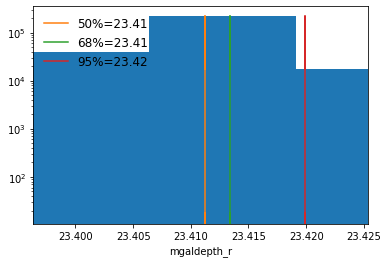

Inside plot_hist


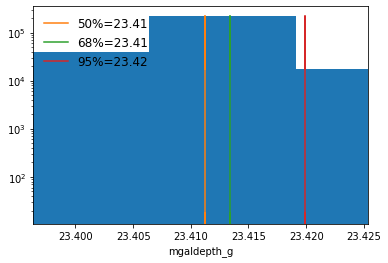

Inside plot_hist


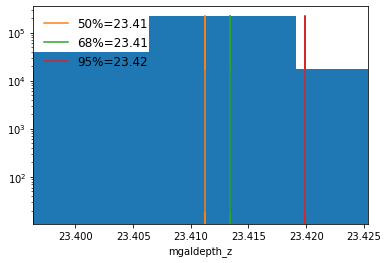

Inside plot_hist


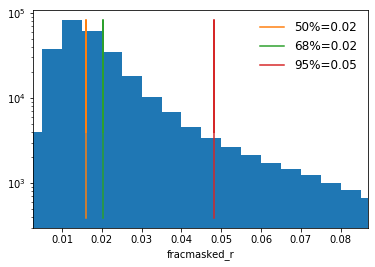

Inside plot_hist


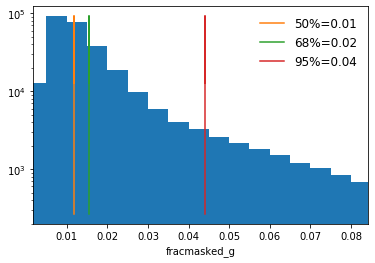

Inside plot_hist


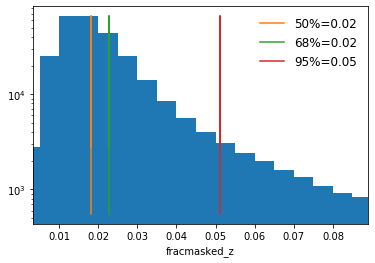

Inside plot_hist
Number of Unique pairs 567589
g-Npairs= 567581
       PSF2  REX2  EXP2  DEV2  COMP 
PSF1: 23.104 3.249 0.121 0.145 0.002
REX1: 3.651 35.995 3.519 1.92 0.002
EXP1: 0.129 3.973 14.949 0.965 0.006
DEV1: 0.163 2.144 0.997 4.925 0.016
COMP1: 0.0 0.001 0.007 0.012 0.003


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

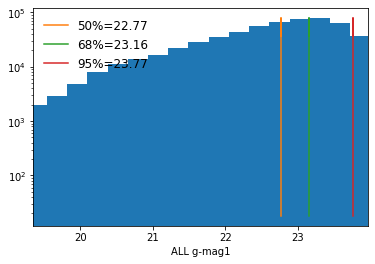

Inside plot_hist


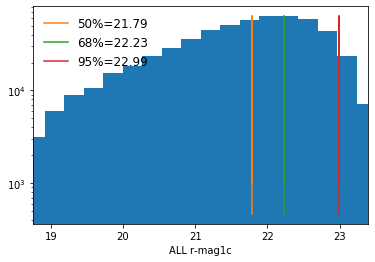

Inside plot_hist


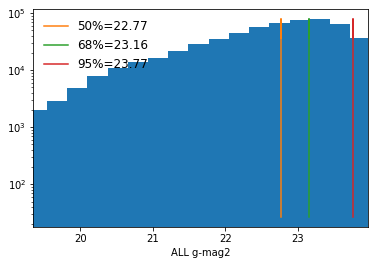

Inside plot_hist


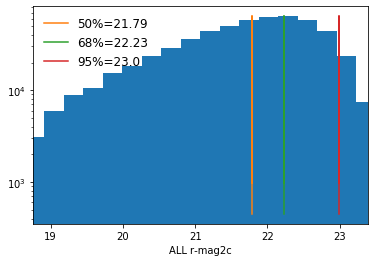

Inside plot_hist


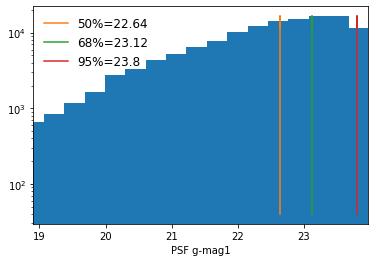

Inside plot_hist


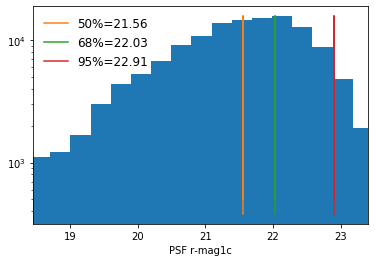

Inside plot_hist


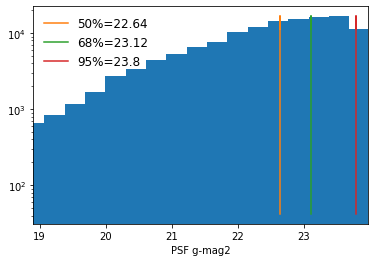

Inside plot_hist


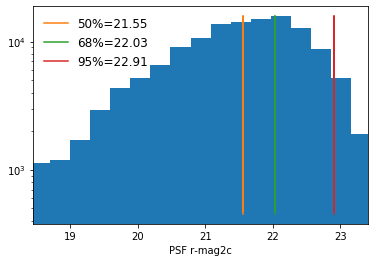

Inside plot_hist


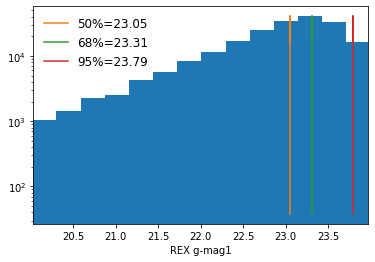

Inside plot_hist


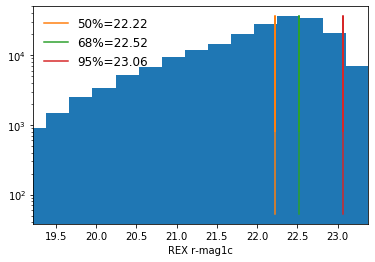

Inside plot_hist


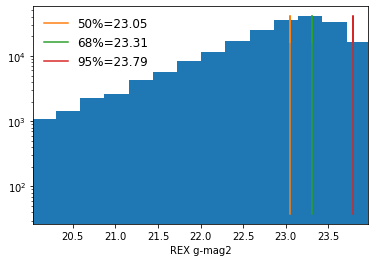

Inside plot_hist


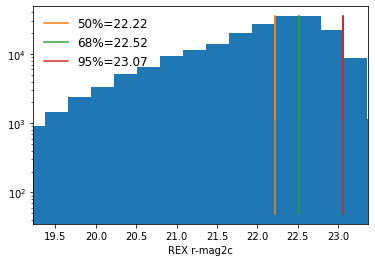

Inside plot_hist


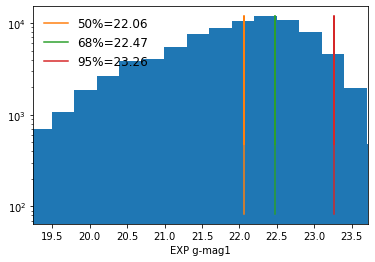

Inside plot_hist


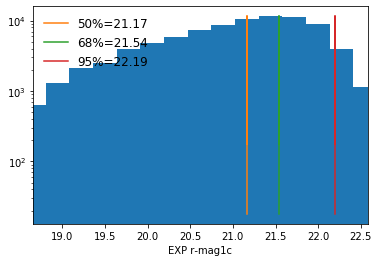

Inside plot_hist


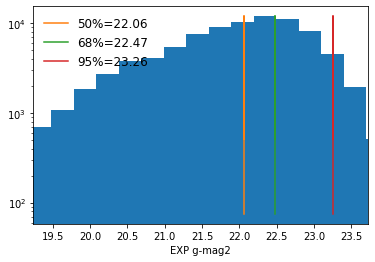

Inside plot_hist


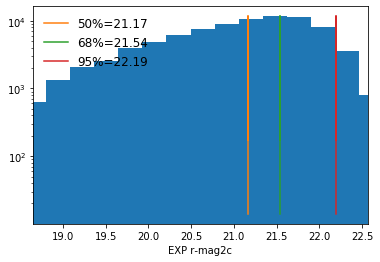

Inside plot_hist
-0.00042152405 0.0002746582 0.00047302246 -0.0006723404
[-9.28429253e-04  1.10676861e+00]


/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/usr/common/software/python/3.7-anaconda-2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


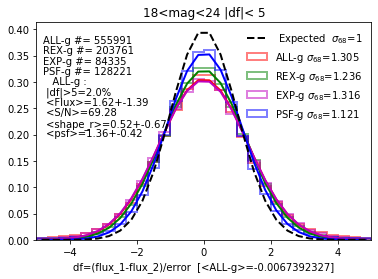

[-0.01679245  1.0842256 ]


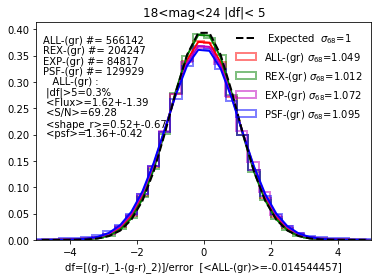

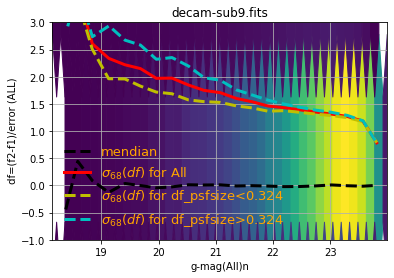

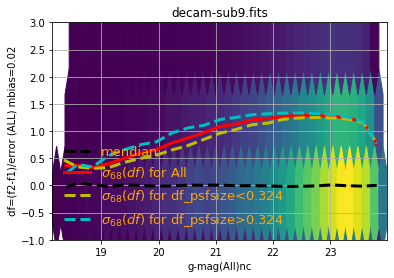

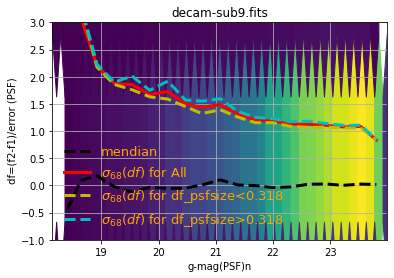

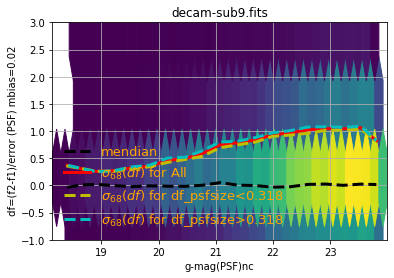

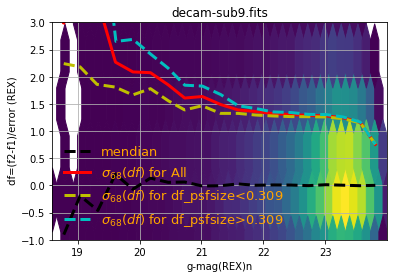

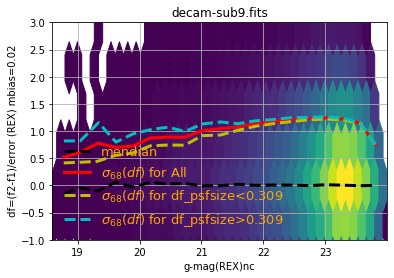

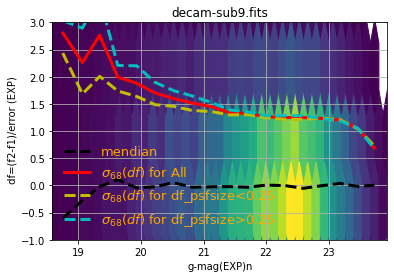

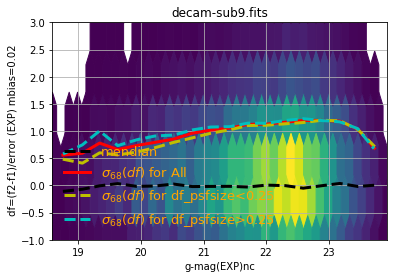

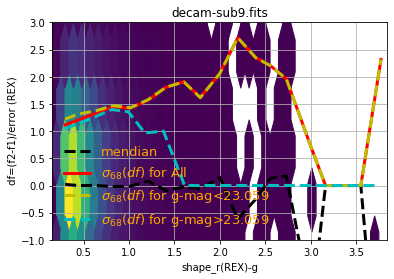

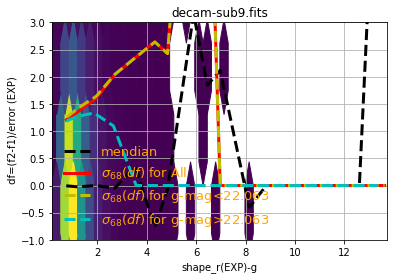

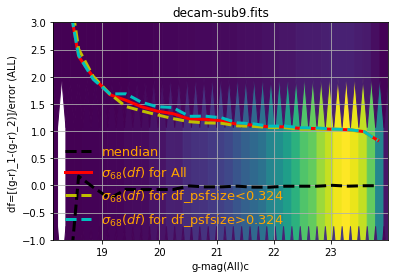

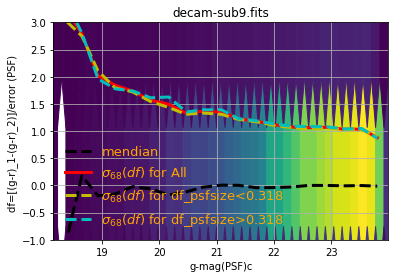

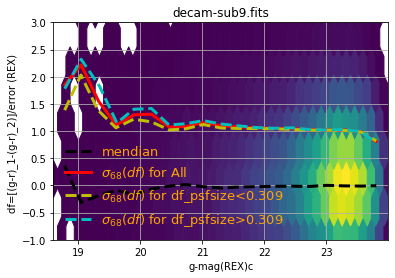

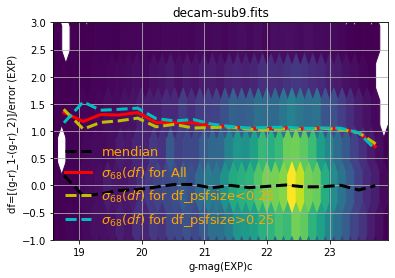

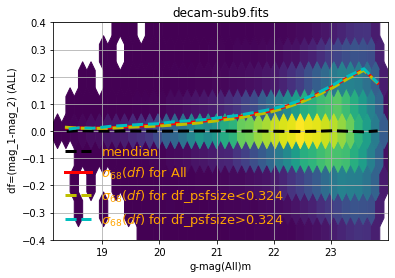

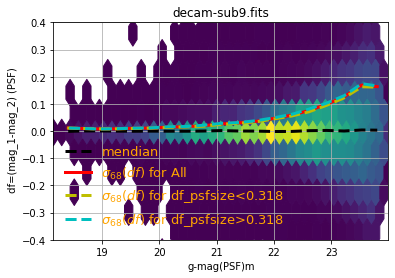

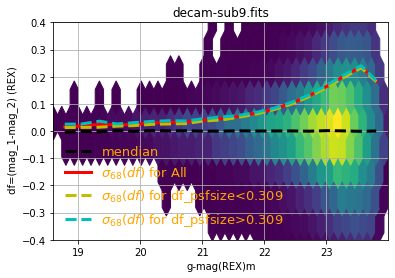

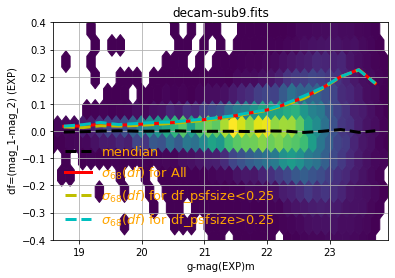

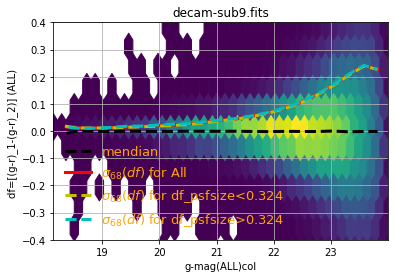

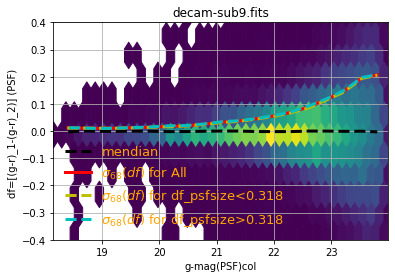

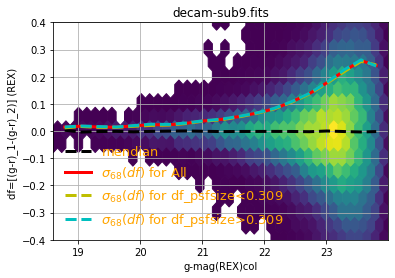

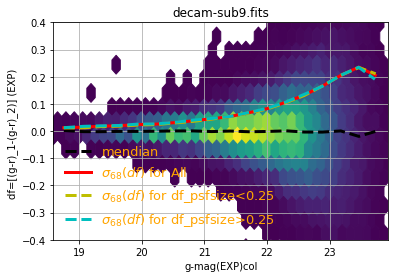

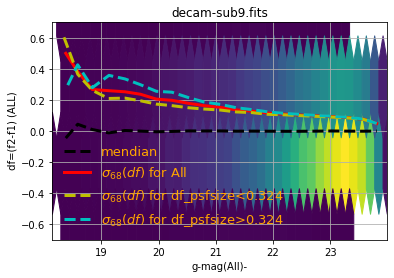

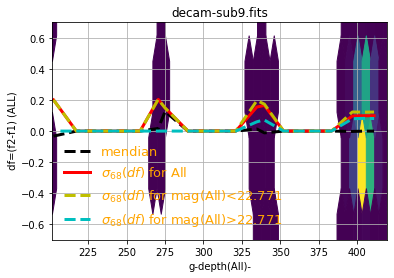

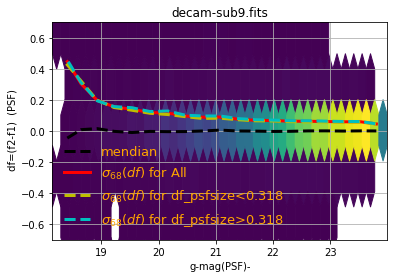

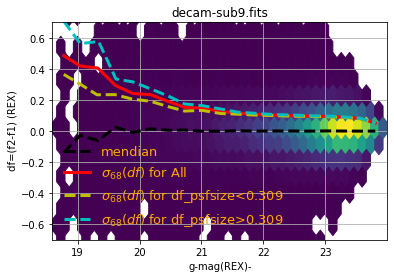

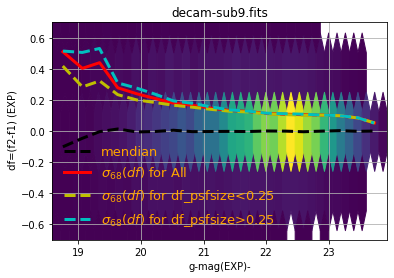

r-Npairs= 567589
       PSF2  REX2  EXP2  DEV2  COMP 
PSF1: 23.105 3.249 0.121 0.145 0.002
REX1: 3.651 35.995 3.519 1.92 0.002
EXP1: 0.129 3.973 14.948 0.965 0.006
DEV1: 0.163 2.144 0.997 4.925 0.016
COMP1: 0.0 0.001 0.007 0.012 0.003


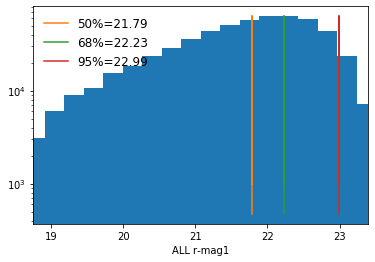

Inside plot_hist


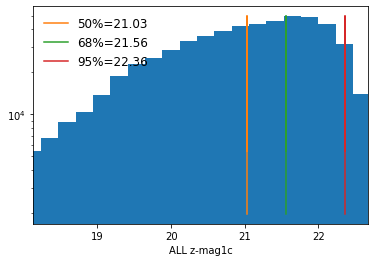

Inside plot_hist


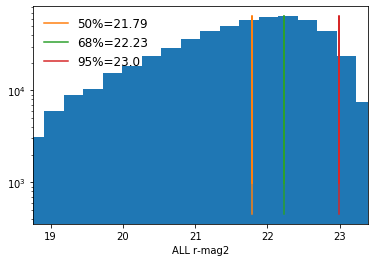

Inside plot_hist


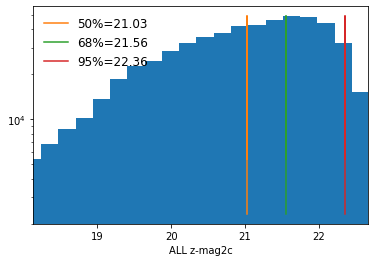

Inside plot_hist


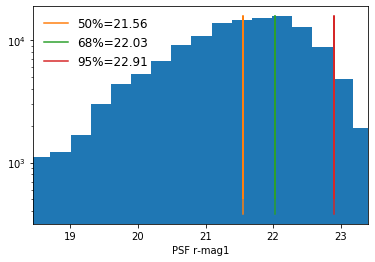

Inside plot_hist


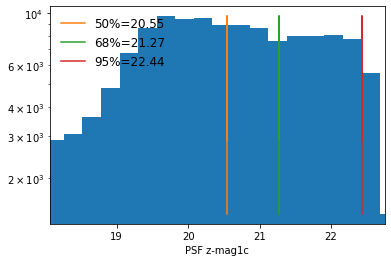

Inside plot_hist


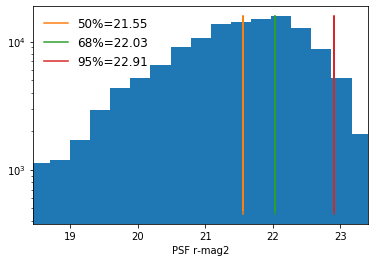

Inside plot_hist


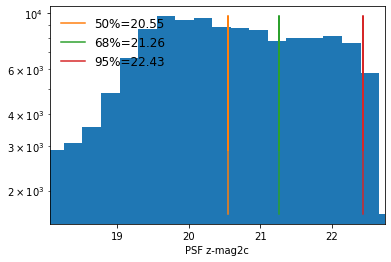

Inside plot_hist


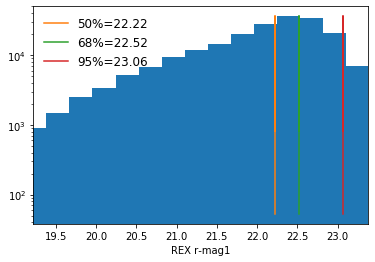

Inside plot_hist


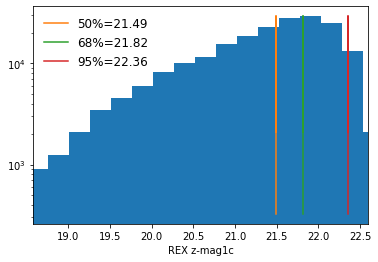

Inside plot_hist


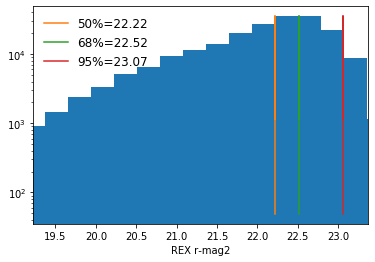

Inside plot_hist


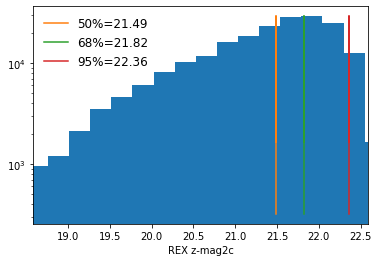

Inside plot_hist


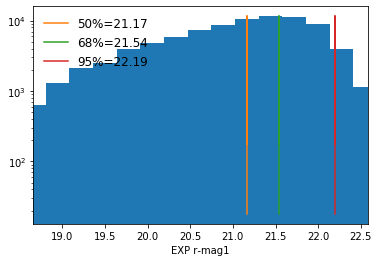

Inside plot_hist


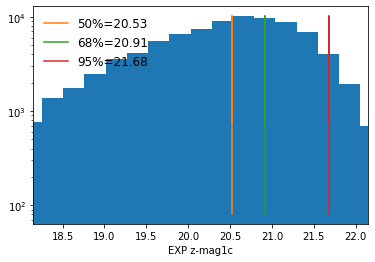

Inside plot_hist


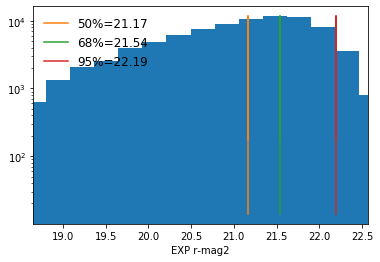

Inside plot_hist


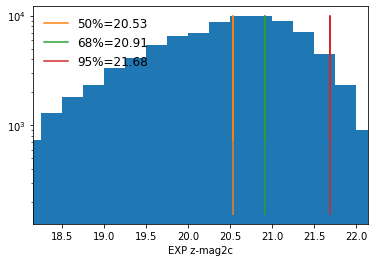

Inside plot_hist
0.0007953644 0.0011062622 0.002111435 0.00040531158
[0.03205897 1.13109614]


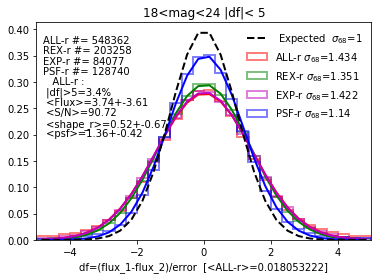

[0.00204797 1.11460545]


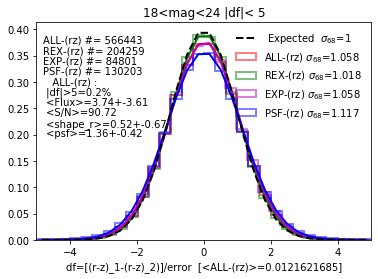

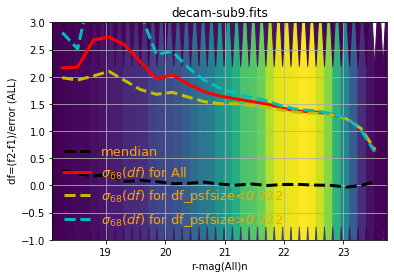

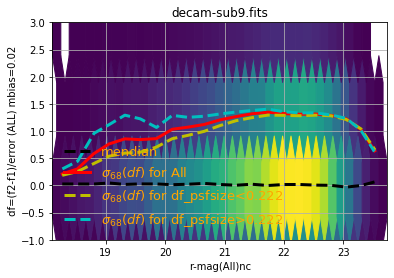

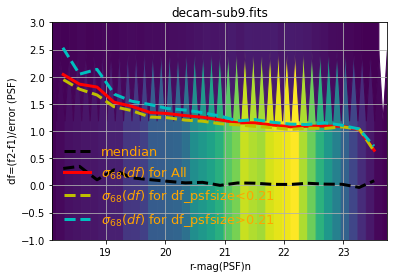

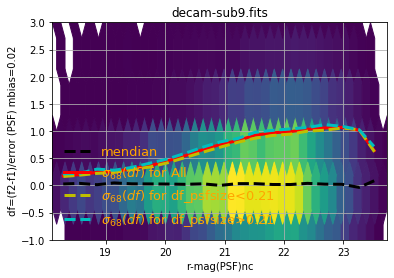

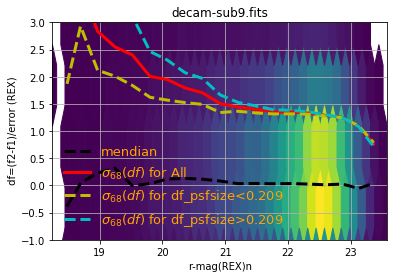

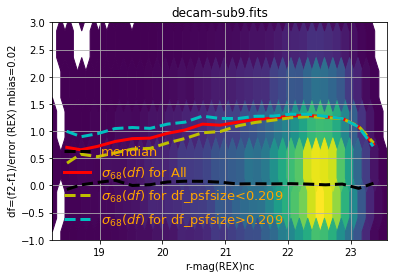

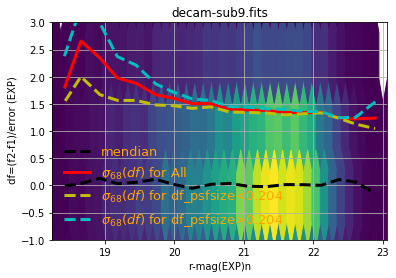

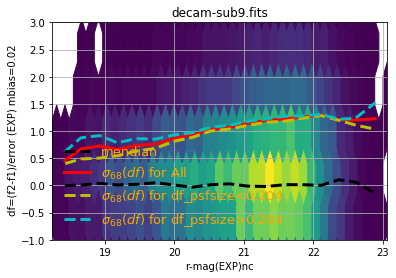

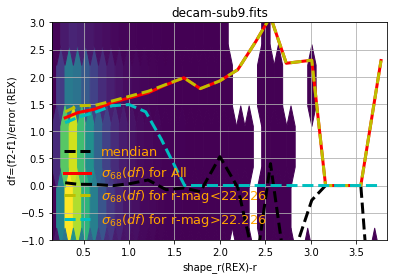

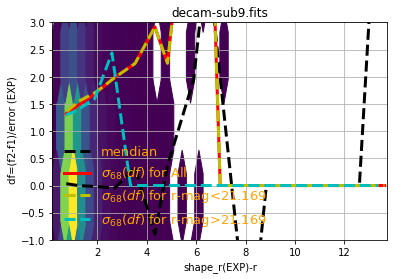

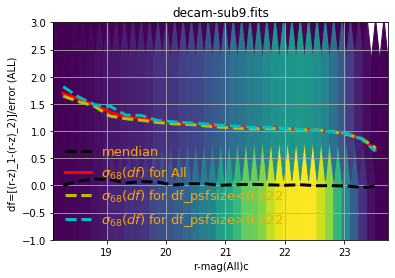

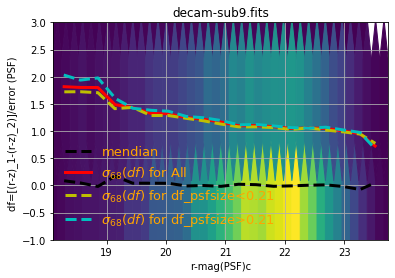

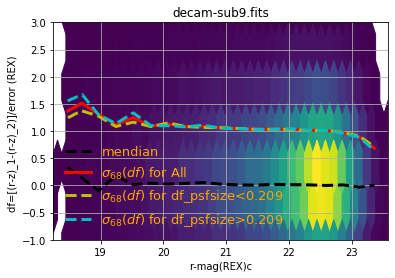

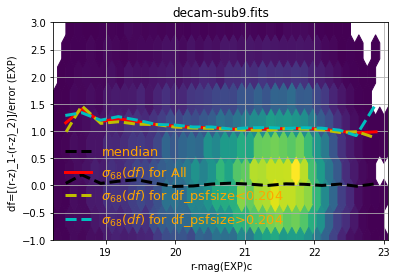

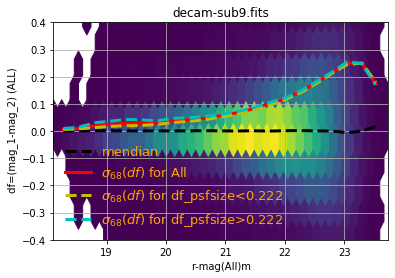

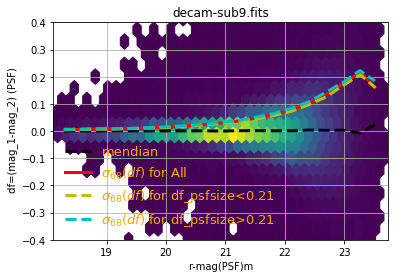

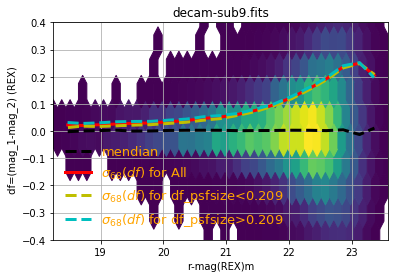

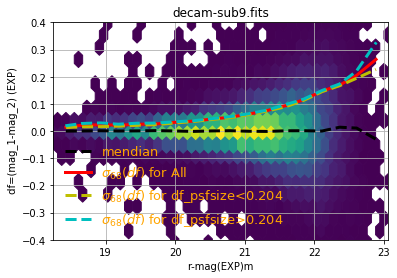

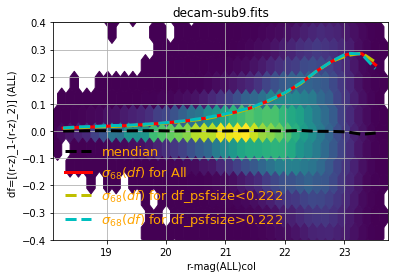

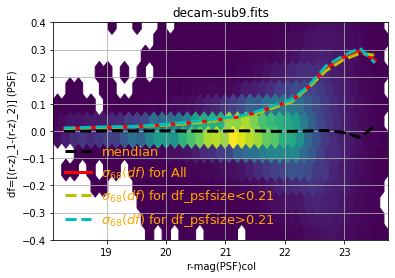

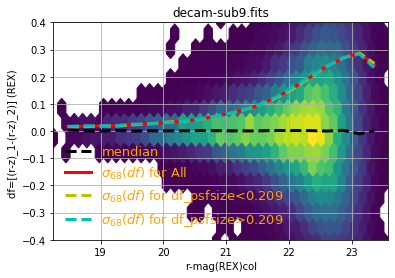

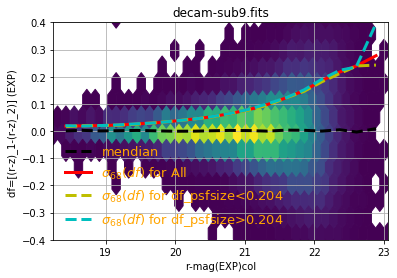

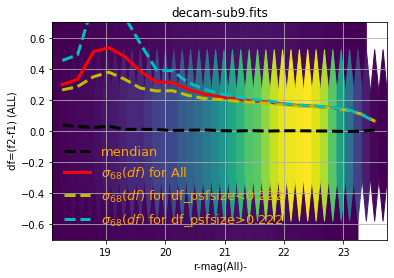

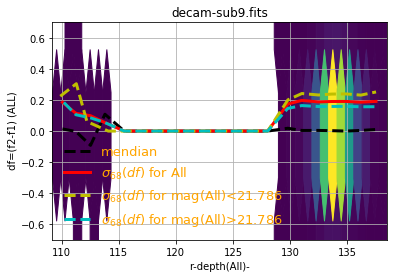

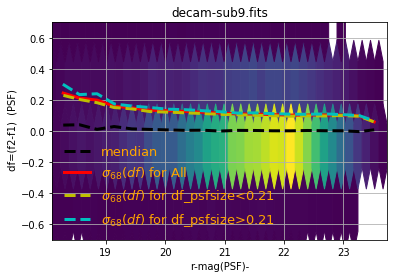

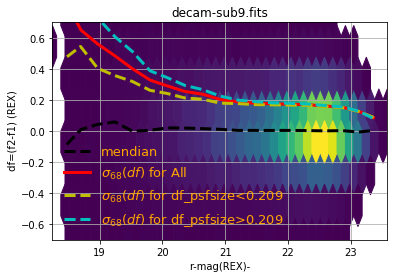

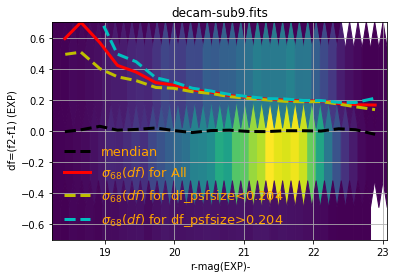

z-Npairs= 567581
       PSF2  REX2  EXP2  DEV2  COMP 
PSF1: 23.104 3.249 0.121 0.145 0.002
REX1: 3.651 35.995 3.519 1.92 0.002
EXP1: 0.129 3.973 14.949 0.965 0.006
DEV1: 0.163 2.144 0.997 4.925 0.016
COMP1: 0.0 0.001 0.007 0.012 0.003


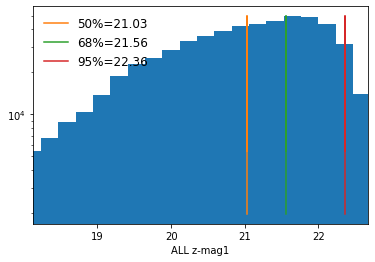

Inside plot_hist


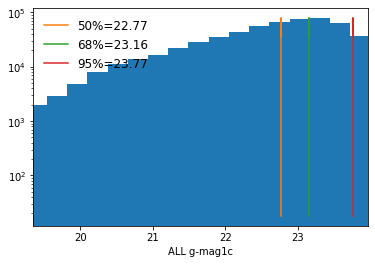

Inside plot_hist


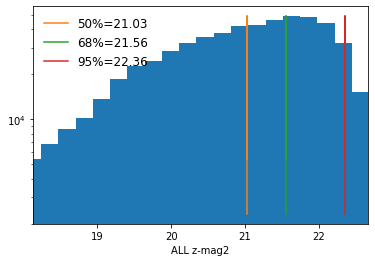

Inside plot_hist


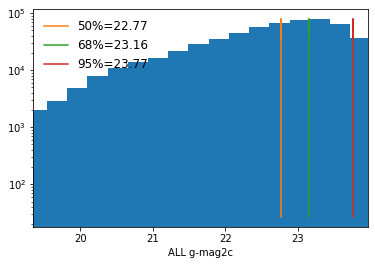

Inside plot_hist


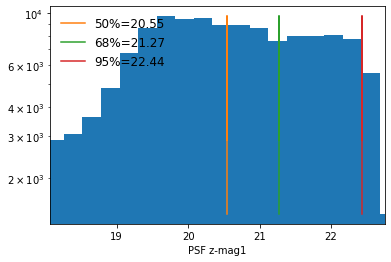

Inside plot_hist


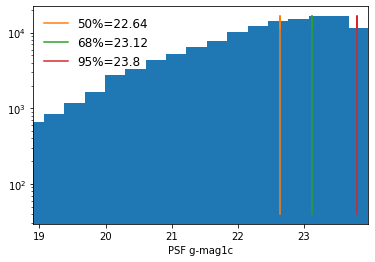

Inside plot_hist


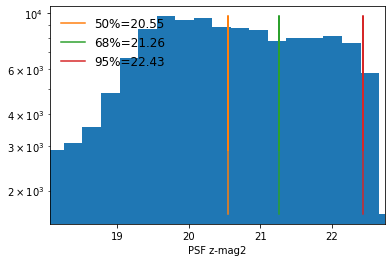

Inside plot_hist


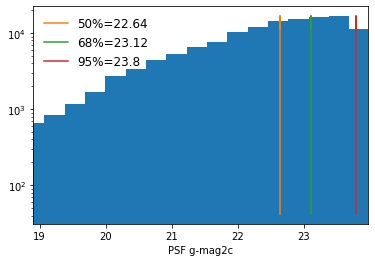

Inside plot_hist


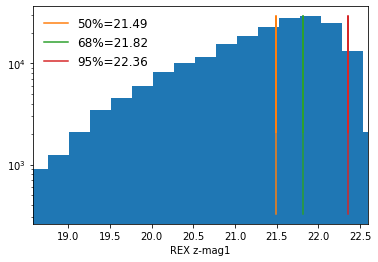

Inside plot_hist


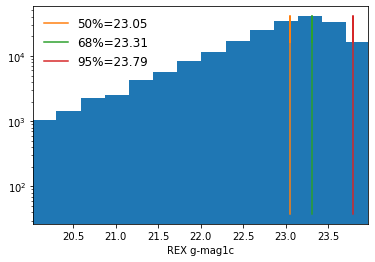

Inside plot_hist


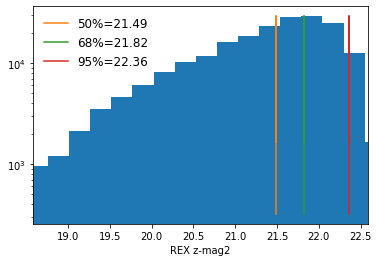

Inside plot_hist


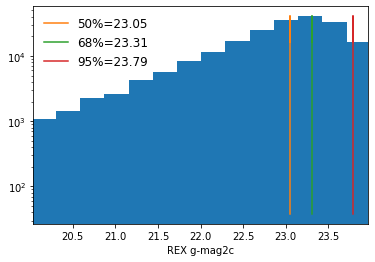

Inside plot_hist


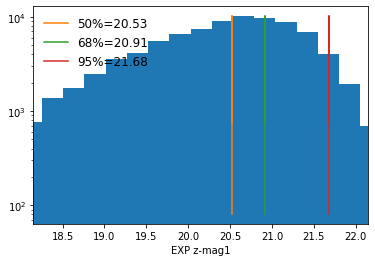

Inside plot_hist


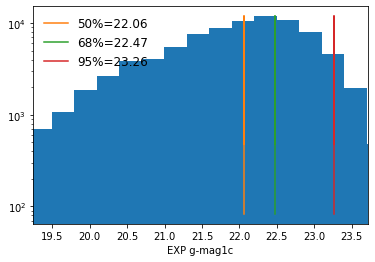

Inside plot_hist


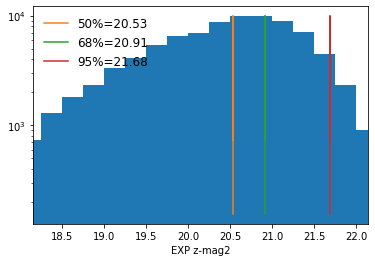

Inside plot_hist


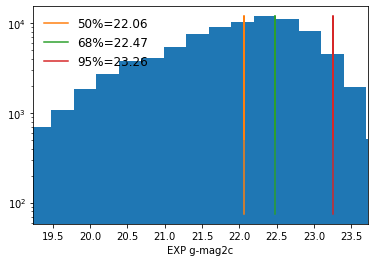

Inside plot_hist
4.196167e-05 0.0008087158 0.00074005127 -0.0008773804
[0.02152389 1.15596454]


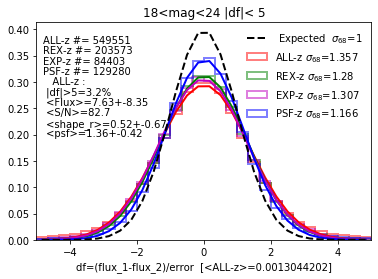

[0.01045215 1.08352201]


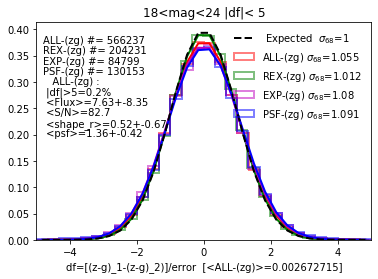

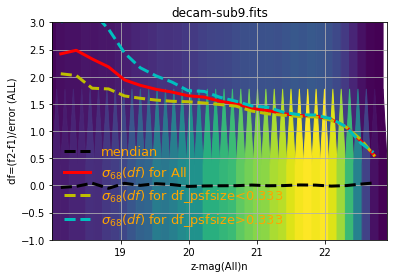

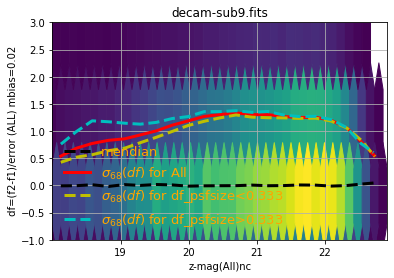

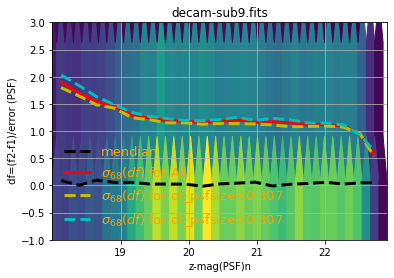

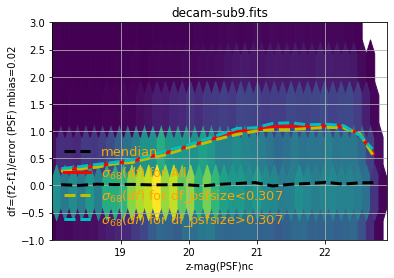

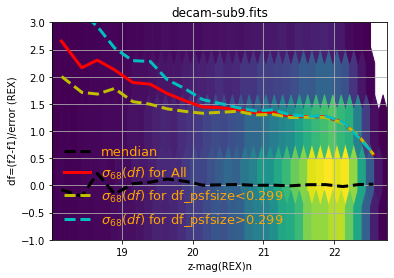

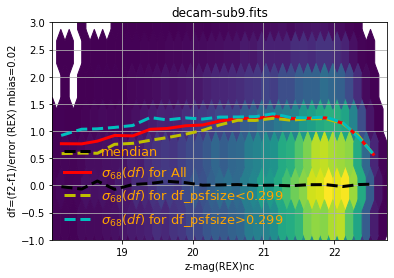

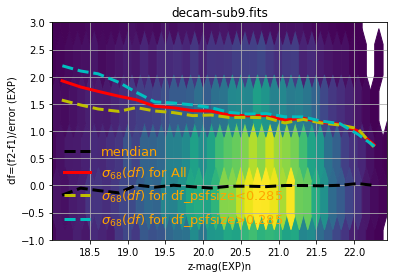

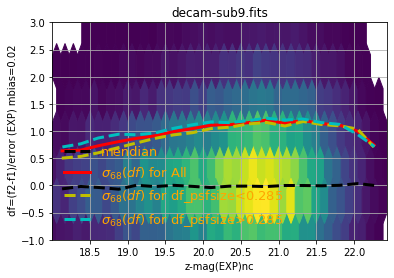

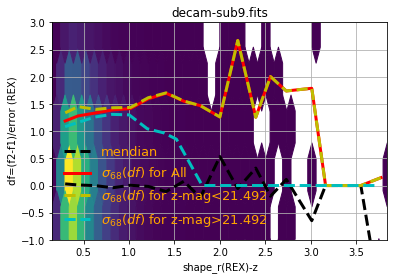

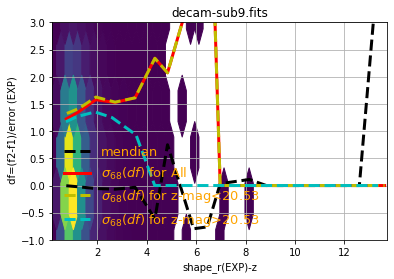

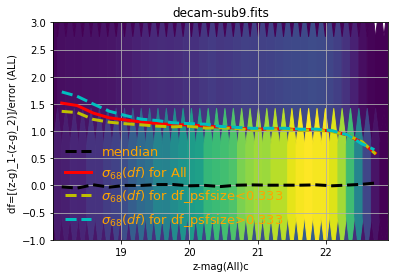

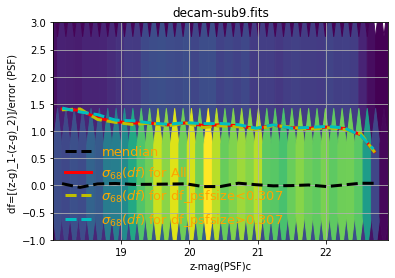

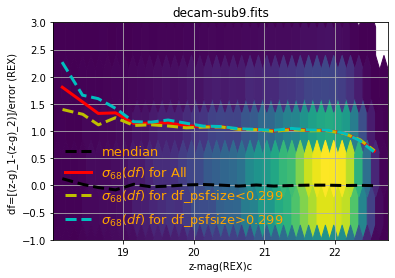

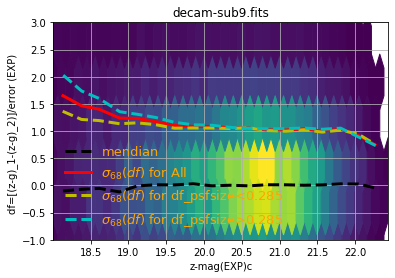

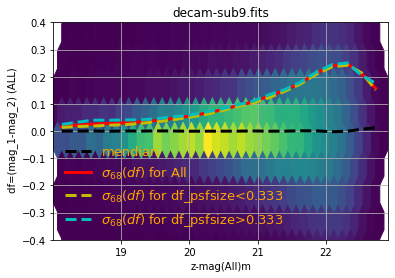

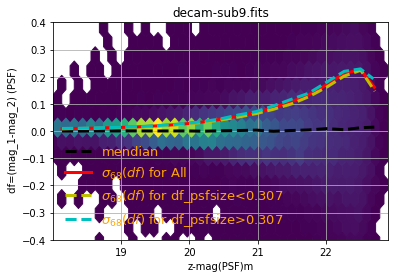

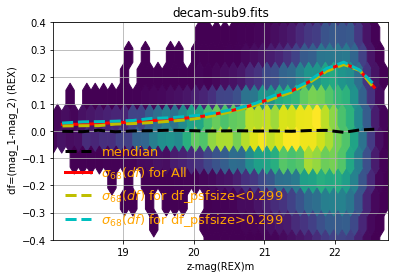

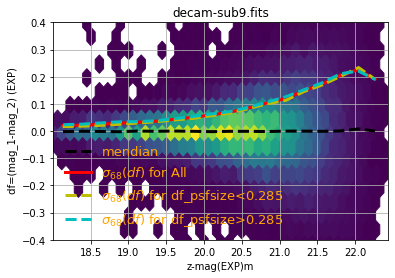

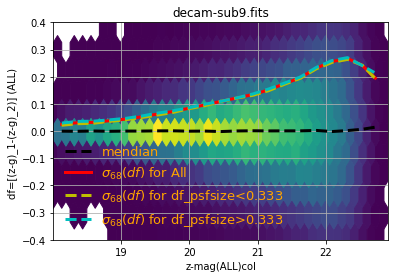

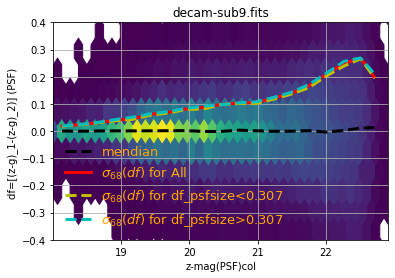

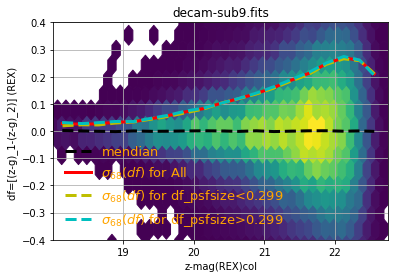

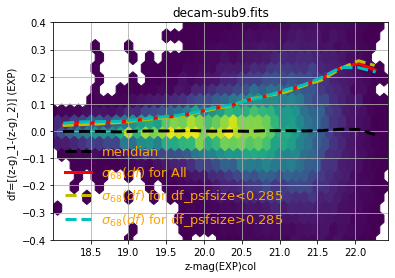

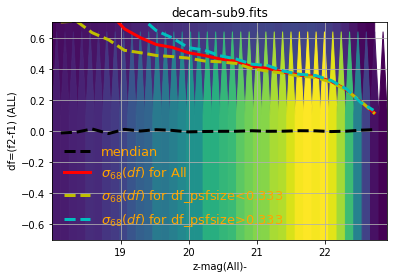

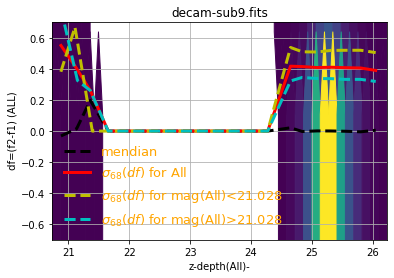

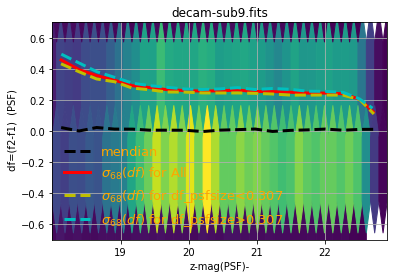

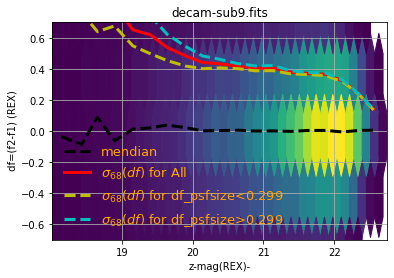

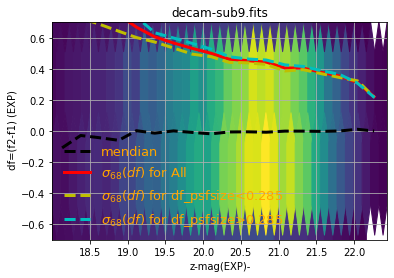

In [12]:
%matplotlib inline
frac=0.10   # this is the maximum fraction of the flux that is masked
m1=18  # min magnitude
m2=24  # max magnitude
bands= ["g","r","z"]
cbands= ["r","z","g"]
nobs_min=2
dfmin=0
dfmax=3
mbias=0.02
matched_size=0.5 # matching resolution in arcsec
#dir="/global/u1/m/manera/DESI/validation-outputs/Vplots-DR8half/"
#dir="Vplots2-dr8" # use this directory to test code with a Gaussian random flux flux_g
#dir="Vplots-dr8" # use this directory for regular run  1 arsec
#dir="Vplots-dr8half" # use this directory for regular run 0.5 arsec
#dir="VplotsStars-dr7" # use this directory for Test run 1 arsec 
#dir="VplotsStars-dr7half" # use this directory for Test run 0.5 arsec
s2ncut=5

# read tractor 
filename="decam-sub0.fits"
dr8sub0=readTractor(dir,filename)
filename="decam-sub1.fits"
dr8sub1=readTractor(dir,filename)
filename="decam-sub2.fits"
dr8sub2=readTractor(dir,filename)
filename="decam-sub3.fits"
dr8sub3=readTractor(dir,filename)
filename="decam-sub4.fits"
dr8sub4=readTractor(dir,filename)
filename="decam-sub5.fits"
dr8sub5=readTractor(dir,filename)
filename="decam-sub6.fits"
dr8sub6=readTractor(dir,filename)
filename="decam-sub7.fits"
dr8sub7=readTractor(dir,filename)
filename="decam-sub8.fits"
dr8sub8=readTractor(dir,filename)
filename="decam-sub9.fits"
dr8sub9=readTractor(dir,filename)

df_result= pd.concat([dr8sub0,dr8sub1,dr8sub2,dr8sub3,dr8sub4,dr8sub5,dr8sub6,dr8sub7,dr8sub8,dr8sub9])

print("All Merged=",len(df_result))


print("All objects=",len(df_result))
npsf=len(df_result[df_result['type'].values=='PSF'])
print('PSF=',npsf,'%=',100.*npsf/len(df_result)) 

# Keep only Duplicates with same ra and dec
dup= df_result.duplicated(subset=["ra","dec"],keep=False)
df_result=df_result[dup==True]  # keep only duplicates
print("Duplicated=",len(df_result))

plot_hist(dir,filename,'shape_r',df_result.shape_r.values+0.01,False)

mag_g=22.5-2.5*np.log10(df_result.flux_g.values)
mag_r=22.5-2.5*np.log10(df_result.flux_r.values)
mag_z=22.5-2.5*np.log10(df_result.flux_z.values)
plot_hist(dir,filename,'mag_g',mag_g,False)
plot_hist(dir,filename,'mag_r',mag_r,False)
plot_hist(dir,filename,'mag_z',mag_z,False)
plot_hist(dir,filename,'psfsize_g',df_result.psfsize_r.values,False)
plot_hist(dir,filename,'psfsize_r',df_result.psfsize_g.values,False)
plot_hist(dir,filename,'psfsize_z',df_result.psfsize_z.values,False)
mgaldepth_g=22.5-2.5*np.log10(5./np.sqrt(np.abs(df_result.galdepth_r.values)))
mgaldepth_r=22.5-2.5*np.log10(5./np.sqrt(np.abs(df_result.galdepth_r.values)))
mgaldepth_z=22.5-2.5*np.log10(5./np.sqrt(np.abs(df_result.galdepth_r.values)))
plot_hist(dir,filename,'mgaldepth_r',mgaldepth_r,False)
plot_hist(dir,filename,'mgaldepth_g',mgaldepth_g,False)
plot_hist(dir,filename,'mgaldepth_z',mgaldepth_z,False)
plot_hist(dir,filename,'fracmasked_r',df_result.fracmasked_r.values,False)
plot_hist(dir,filename,'fracmasked_g',df_result.fracmasked_g.values,False)
plot_hist(dir,filename,'fracmasked_z',df_result.fracmasked_z.values,False)

plot_Brickvalues(dir,filename,'mgaldepth_g',mgaldepth_g,df_result.bx.values,df_result.by.values)
plot_Brickvalues(dir,filename,'mgaldepth_r',mgaldepth_r,df_result.bx.values,df_result.by.values)
plot_Brickvalues(dir,filename,'mgaldepth_z',mgaldepth_z,df_result.bx.values,df_result.by.values)
plot_Brickvalues(dir,filename,'mag_g',mag_g,df_result.bx.values,df_result.by.values)
plot_Brickvalues(dir,filename,'mag_r',mag_r,df_result.bx.values,df_result.by.values)
plot_Brickvalues(dir,filename,'mag_z',mag_z,df_result.bx.values,df_result.by.values)

# Find All pairs with same RA and DEC
df_result2=df_result
df_join=pd.merge(df_result2,df_result2,on=["ra","dec"])

# unique pairs
#df_join=df_join[df_join.bx_x.values>df_join.bx_y.values]
df_join=df_join[df_join.galdepth_r_x.values>df_join.galdepth_r_y.values]


print("Number of Unique pairs",len(df_join))


for iband in np.arange(len(bands)):
    band=bands[iband]
    cband=cbands[iband]

    sel = ((df_join['flux_'+band+'_x'].values>s2ncut/np.sqrt(df_join['flux_ivar_'+band+'_x'].values)) &
           (df_join['flux_'+cband+'_x'].values>s2ncut/np.sqrt(df_join['flux_ivar_'+cband+'_x'].values)) &
           (df_join['flux_'+band+'_y'].values>s2ncut/np.sqrt(df_join['flux_ivar_'+band+'_y'].values)) &
           (df_join['flux_'+cband+'_y'].values>s2ncut/np.sqrt(df_join['flux_ivar_'+cband+'_y'].values)) &
           (df_join['galdepth_'+band+'_x'].values>0)&
           (df_join['galdepth_'+cband+'_x'].values>0)&  
           (df_join['galdepth_'+band+'_y'].values>0)&
           (df_join['galdepth_'+cband+'_y'].values>0)&             
           (df_join['fracmasked_'+band+'_x'].values<frac)&
           (df_join['fracmasked_'+cband+'_x'].values<frac)& 
           (df_join['fracmasked_'+band+'_y'].values<frac)&
           (df_join['fracmasked_'+cband+'_y'].values<frac))           
    df_join2=df_join[sel]
    sel2= (df_join2['type_x'].values=='PSF') & (df_join2['type_y'].values=='PSF')
    df_psf2=df_join2[sel2]  
    sel2= (df_join2['type_x'].values=='REX') & (df_join2['type_y'].values=='REX')
    df_rex2=df_join2[sel2]
    sel2= (df_join2['type_x'].values=='EXP') & (df_join2['type_y'].values=='EXP')    
    df_exp2=df_join2[sel2]  

    nt=len(df_join2)
    print(band+'-Npairs=',nt)
    print('       PSF2  REX2  EXP2  DEV2  COMP ')
    print('PSF1:',np.round(100*len(df_join2[((df_join2['type_x'].values=='PSF') & (df_join2['type_y'].values=='PSF'))])/nt,3),
         np.round(100*len(df_join2[((df_join2['type_x'].values=='PSF') & (df_join2['type_y'].values=='REX'))])/nt,3),
         np.round(100*len(df_join2[((df_join2['type_x'].values=='PSF') & (df_join2['type_y'].values=='EXP'))])/nt,3),
         np.round(100*len(df_join2[((df_join2['type_x'].values=='PSF') & (df_join2['type_y'].values=='DEV'))])/nt,3), 
         np.round(100*len(df_join2[((df_join2['type_x'].values=='PSF') & (df_join2['type_y'].values=='COMP'))])/nt,3))
    print('REX1:',np.round(100*len(df_join2[((df_join2['type_x'].values=='REX') & (df_join2['type_y'].values=='PSF'))])/nt,3),
         np.round(100*len(df_join2[((df_join2['type_x'].values=='REX') & (df_join2['type_y'].values=='REX'))])/nt,3),
         np.round(100*len(df_join2[((df_join2['type_x'].values=='REX') & (df_join2['type_y'].values=='EXP'))])/nt,3),
         np.round(100*len(df_join2[((df_join2['type_x'].values=='REX') & (df_join2['type_y'].values=='DEV'))])/nt,3), 
         np.round(100*len(df_join2[((df_join2['type_x'].values=='REX') & (df_join2['type_y'].values=='COMP'))])/nt,3))      
    print('EXP1:',np.round(100*len(df_join2[((df_join2['type_x'].values=='EXP') & (df_join2['type_y'].values=='PSF'))])/nt,3),
         np.round(100*len(df_join2[((df_join2['type_x'].values=='EXP') & (df_join2['type_y'].values=='REX'))])/nt,3),
         np.round(100*len(df_join2[((df_join2['type_x'].values=='EXP') & (df_join2['type_y'].values=='EXP'))])/nt,3),
         np.round(100*len(df_join2[((df_join2['type_x'].values=='EXP') & (df_join2['type_y'].values=='DEV'))])/nt,3), 
         np.round(100*len(df_join2[((df_join2['type_x'].values=='EXP') & (df_join2['type_y'].values=='COMP'))])/nt,3))  
    print('DEV1:',np.round(100*len(df_join2[((df_join2['type_x'].values=='DEV') & (df_join2['type_y'].values=='PSF'))])/nt,3),
         np.round(100*len(df_join2[((df_join2['type_x'].values=='DEV') & (df_join2['type_y'].values=='REX'))])/nt,3),
         np.round(100*len(df_join2[((df_join2['type_x'].values=='DEV') & (df_join2['type_y'].values=='EXP'))])/nt,3),
         np.round(100*len(df_join2[((df_join2['type_x'].values=='DEV') & (df_join2['type_y'].values=='DEV'))])/nt,3), 
         np.round(100*len(df_join2[((df_join2['type_x'].values=='DEV') & (df_join2['type_y'].values=='COMP'))])/nt,3))  
    print('COMP1:',np.round(100*len(df_join2[((df_join2['type_x'].values=='COMP') & (df_join2['type_y'].values=='PSF'))])/nt,3),
         np.round(100*len(df_join2[((df_join2['type_x'].values=='COMP') & (df_join2['type_y'].values=='REX'))])/nt,3),
         np.round(100*len(df_join2[((df_join2['type_x'].values=='COMP') & (df_join2['type_y'].values=='EXP'))])/nt,3),
         np.round(100*len(df_join2[((df_join2['type_x'].values=='COMP') & (df_join2['type_y'].values=='DEV'))])/nt,3), 
         np.round(100*len(df_join2[((df_join2['type_x'].values=='COMP') & (df_join2['type_y'].values=='COMP'))])/nt,3))      

    f1=df_join2['flux_'+band+'_x'].values
    f2=df_join2['flux_'+band+'_y'].values    
    ef1=np.sqrt(1./df_join2['flux_ivar_'+band+'_x'].values)
    ef2=np.sqrt(1./df_join2['flux_ivar_'+band+'_y'].values)   

    f1c=df_join2['flux_'+cband+'_x'].values
    f2c=df_join2['flux_'+cband+'_y'].values    
    ef1c=np.sqrt(1./df_join2['flux_ivar_'+cband+'_x'].values)
    ef2c=np.sqrt(1./df_join2['flux_ivar_'+cband+'_y'].values)   
    
    df= (f2-f1)/(np.sqrt(ef1**2+ef2**2))
    dfc= (f2-f1)/(np.sqrt(ef1**2+ef2**2+(mbias*f1)**2+(mbias*f2)**2))    
    dfr= (f2-f1)  
    dfrALL=dfr
    mag1=22.5-2.5*np.log10(f1)
    mag1c=22.5-2.5*np.log10(f1c)  
    mag2=22.5-2.5*np.log10(f2)
    mag2c=22.5-2.5*np.log10(f2c)
    mag=22.5-2.5*np.log10(0.5*(f1+f2))   
    magALL=mag
    col1=mag1-mag1c
    col2=mag2-mag2c  
    dmagALL=mag1-mag2
    dcolALL=col1-col2
    ecol1=2.5/np.log(10)*np.sqrt((ef1/f1)**2+(ef1c/f1c)**2) 
    ecol2=2.5/np.log(10)*np.sqrt((ef2/f2)**2+(ef2c/f2c)**2)  
    cdfALL=(col1-col2)/np.sqrt(ecol1**2+ecol2**2)  
    mean_depth=0.5*(df_join2['galdepth_'+band+'_y'].values+df_join2['galdepth_'+band+'_x'].values)
    df_psfsize=np.abs(df_join2['psfsize_'+band+'_y'].values-df_join2['psfsize_'+band+'_x'].values)
    df_fracmasked=np.abs(df_join2['fracmasked_'+band+'_y'].values-df_join2['fracmasked_'+band+'_x'].values)    
    plot_hist(dir,filename,'ALL '+band+'-mag1',mag1,False)
    plot_hist(dir,filename,'ALL '+cband+'-mag1c',mag1c,False)
    plot_hist(dir,filename,'ALL '+band+'-mag2',mag2,False)
    plot_hist(dir,filename,'ALL '+cband+'-mag2c',mag2c,False)    

    s2n=np.sqrt(np.average((((f1+f2)/2)**2/((ef2/2)**2+(ef1/2)**2))))  # average
    mean_f=np.average(f1+f2)/2
    std_f=(sigma_68(f1)+sigma_68(f2))/np.sqrt(2.)
    mean_psf=(np.average(df_join2.psfsize_g_x.values)+np.average(df_join2.psfsize_g_y.values))/2

    std_psf=(sigma_68(df_join2.psfsize_g_x.values)+sigma_68(df_join2.psfsize_g_y.values))/np.sqrt(2.)
    mean_dpsf=(np.average(np.abs(df_join2.psfsize_g_x.values-df_join2.psfsize_g_y.values)))
    mean_r50=(np.average(df_join2.shape_r_x.values)+np.average(df_join2.shape_r_y.values))/2
    std_r50=(sigma_68(df_join2.shape_r_x.values)+sigma_68(df_join2.shape_r_y.values))/np.sqrt(2.)
    df_cut=5
    
    f1=df_psf2['flux_'+band+'_x'].values
    f2=df_psf2['flux_'+band+'_y'].values    
    ef1=np.sqrt(1./df_psf2['flux_ivar_'+band+'_x'].values)
    ef2=np.sqrt(1./df_psf2['flux_ivar_'+band+'_y'].values)
    f1c=df_psf2['flux_'+cband+'_x'].values
    f2c=df_psf2['flux_'+cband+'_y'].values    
    ef1c=np.sqrt(1./df_psf2['flux_ivar_'+cband+'_x'].values)
    ef2c=np.sqrt(1./df_psf2['flux_ivar_'+cband+'_y'].values)    
    dfpsf= (f2-f1)/(np.sqrt(ef1**2+ef2**2))
    dfpsfc= (f2-f1)/(np.sqrt(ef1**2+ef2**2+(mbias*f1)**2+(mbias*f2)**2))
    dfrpsf= (f2-f1)      
    mag1=22.5-2.5*np.log10(f1)
    mag1c=22.5-2.5*np.log10(f1c)  
    mag2=22.5-2.5*np.log10(f2)
    mag2c=22.5-2.5*np.log10(f2c) 

    magpsf=22.5-2.5*np.log10(0.5*(f1+f2))     
    col1=mag1-mag1c
    col2=mag2-mag2c 
    dmagpsf=mag1-mag2   
    dcolpsf=col1-col2    
    ecol1=2.5/np.log(10)*np.sqrt((ef1/f1)**2+(ef1c/f1c)**2) 
    ecol2=2.5/np.log(10)*np.sqrt((ef2/f2)**2+(ef2c/f2c)**2)  
    cdfpsf=(col1-col2)/np.sqrt(ecol1**2+ecol2**2)   
    plot_hist(dir,filename,'PSF '+band+'-mag1',mag1,False) 
    plot_hist(dir,filename,'PSF '+cband+'-mag1c',mag1c,False) 
    plot_hist(dir,filename,'PSF '+band+'-mag2',mag2,False) 
    plot_hist(dir,filename,'PSF '+cband+'-mag2c',mag2c,False)      
    dfpsf_psfsize=np.abs(df_psf2['psfsize_'+band+'_y'].values-df_psf2['psfsize_'+band+'_x'].values)
    dfpsf_fracmasked=np.abs(df_psf2['fracmasked_'+band+'_y'].values-df_psf2['fracmasked_'+band+'_x'].values) 

   
    
    f1=df_rex2['flux_'+band+'_x'].values
    f2=df_rex2['flux_'+band+'_y'].values    
    ef1=np.sqrt(1./df_rex2['flux_ivar_'+band+'_x'].values)
    ef2=np.sqrt(1./df_rex2['flux_ivar_'+band+'_y'].values) 
    f1c=df_rex2['flux_'+cband+'_x'].values
    f2c=df_rex2['flux_'+cband+'_y'].values    
    ef1c=np.sqrt(1./df_rex2['flux_ivar_'+cband+'_x'].values)
    ef2c=np.sqrt(1./df_rex2['flux_ivar_'+cband+'_y'].values)      
    dfrex= (f2-f1)/(np.sqrt(ef1**2+ef2**2))
    dfrexc= (f2-f1)/(np.sqrt(ef1**2+ef2**2+(mbias*f1)**2+(mbias*f2)**2))
    dfrrex= (f2-f1) 
    mag1=22.5-2.5*np.log10(f1)
    mag1c=22.5-2.5*np.log10(f1c)  
    mag2=22.5-2.5*np.log10(f2)
    mag2c=22.5-2.5*np.log10(f2c)  

    magrex=22.5-2.5*np.log10(0.5*(f1+f2))    
    col1=mag1-mag1c
    col2=mag2-mag2c  
    dmagrex=mag1-mag2  
    dcolrex=col1-col2    
    ecol1=2.5/np.log(10)*np.sqrt((ef1/f1)**2+(ef1c/f1c)**2) 
    ecol2=2.5/np.log(10)*np.sqrt((ef2/f2)**2+(ef2c/f2c)**2)  
    cdfrex=(col1-col2)/np.sqrt(ecol1**2+ecol2**2) 
    plot_hist(dir,filename,'REX '+band+'-mag1',mag1,False) 
    plot_hist(dir,filename,'REX '+cband+'-mag1c',mag1c,False) 
    plot_hist(dir,filename,'REX '+band+'-mag2',mag2,False) 
    plot_hist(dir,filename,'REX '+cband+'-mag2c',mag2c,False)      
    shape_r_rex=(df_rex2['shape_r_x'].values+df_rex2['shape_r_y'].values)/2.    
    dfrex_psfsize=np.abs(df_rex2['psfsize_'+band+'_y'].values-df_rex2['psfsize_'+band+'_x'].values)
    dfrex_fracmasked=np.abs(df_rex2['fracmasked_'+band+'_y'].values-df_rex2['fracmasked_'+band+'_x'].values)     

    
    f1=df_exp2['flux_'+band+'_x'].values
    f2=df_exp2['flux_'+band+'_y'].values    
    ef1=np.sqrt(1./df_exp2['flux_ivar_'+band+'_x'].values)
    ef2=np.sqrt(1./df_exp2['flux_ivar_'+band+'_y'].values)
    f1c=df_exp2['flux_'+cband+'_x'].values
    f2c=df_exp2['flux_'+cband+'_y'].values    
    ef1c=np.sqrt(1./df_exp2['flux_ivar_'+cband+'_x'].values)
    ef2c=np.sqrt(1./df_exp2['flux_ivar_'+cband+'_y'].values)          
    dfexp= (f2-f1)/(np.sqrt(ef1**2+ef2**2))
    dfexpc= (f2-f1)/(np.sqrt(ef1**2+ef2**2+(mbias*f1)**2+(mbias*f2)**2))    
    dfrexp= (f2-f1)     
    mag1=22.5-2.5*np.log10(f1)
    mag1c=22.5-2.5*np.log10(f1c)  
    mag2=22.5-2.5*np.log10(f2)
    mag2c=22.5-2.5*np.log10(f2c)
    magexp=22.5-2.5*np.log10(0.5*(f1+f2)) 
    col1=mag1-mag1c
    col2=mag2-mag2c  
    dmagexp=mag1-mag2
    dcolexp=col1-col2    
    
    ecol1=2.5/np.log(10)*np.sqrt((ef1/f1)**2+(ef1c/f1c)**2) 
    ecol2=2.5/np.log(10)*np.sqrt((ef2/f2)**2+(ef2c/f2c)**2)  
    cdfexp=(col1-col2)/np.sqrt(ecol1**2+ecol2**2)
    plot_hist(dir,filename,'EXP '+band+'-mag1',mag1,False) 
    plot_hist(dir,filename,'EXP '+cband+'-mag1c',mag1c,False) 
    plot_hist(dir,filename,'EXP '+band+'-mag2',mag2,False) 
    plot_hist(dir,filename,'EXP '+cband+'-mag2c',mag2c,False)  
    shape_r_exp=(df_exp2['shape_r_x'].values+df_exp2['shape_r_y'].values)/2.    
    dfexp_psfsize=np.abs(df_exp2['psfsize_'+band+'_y'].values-df_exp2['psfsize_'+band+'_x'].values) 
    dfexp_fracmasked=np.abs(df_exp2['fracmasked_'+band+'_y'].values-df_exp2['fracmasked_'+band+'_x'].values)     

    print(np.median(dmagALL),np.median(dmagpsf),np.median(dmagrex),np.median(dmagexp))

    CX="df=(flux_1-flux_2)/error  "
    draw_histdf(dir,CX,'ALL-'+band,df,'REX-'+band,dfrex,'EXP-'+band,dfexp,'PSF-'+band,dfpsf,filename)

    CX="df=[("+band+"-"+cband+")_1-("+band+"-"+cband+")_2)]/error  "
    draw_histdf(dir,CX,'ALL-('+band+cband+')',cdfALL,'REX-('+band+cband+')',cdfrex,'EXP-('+band+cband+')',cdfexp,'PSF-('+band+cband+')',cdfpsf,filename)

    dfmin=-1
    dfmax=3
    
    Cdf=" df=(f2-f1)/error (ALL)"
    CdfPSF=" df=(f2-f1)/error (PSF)"
    CdfREX=" df=(f2-f1)/error (REX)"
    CdfEXP=" df=(f2-f1)/error (EXP)"
    draw2_sigma68(dir,Cdf,df,band+"-mag(All)n",mag,"df_psfsize",df_psfsize,filename,dfmin,dfmax)    
    draw2_sigma68(dir,Cdf+" mbias="+str(mbias),dfc,band+"-mag(All)nc",mag,"df_psfsize",df_psfsize,filename,dfmin,dfmax)
    draw2_sigma68(dir,CdfPSF,dfpsf,band+"-mag(PSF)n",magpsf,"df_psfsize",dfpsf_psfsize,filename,dfmin,dfmax)  
    draw2_sigma68(dir,CdfPSF+" mbias="+str(mbias),dfpsfc,band+"-mag(PSF)nc",magpsf,"df_psfsize",dfpsf_psfsize,filename,dfmin,dfmax)      
    draw2_sigma68(dir,CdfREX,dfrex,band+"-mag(REX)n",magrex,"df_psfsize",dfrex_psfsize,filename,dfmin,dfmax) 
    draw2_sigma68(dir,CdfREX+" mbias="+str(mbias),dfrexc,band+"-mag(REX)nc",magrex,"df_psfsize",dfrex_psfsize,filename,dfmin,dfmax) 
    draw2_sigma68(dir,CdfEXP,dfexp,band+"-mag(EXP)n",magexp,"df_psfsize",dfexp_psfsize,filename,dfmin,dfmax)     
    draw2_sigma68(dir,CdfEXP+" mbias="+str(mbias),dfexpc,band+"-mag(EXP)nc",magexp,"df_psfsize",dfexp_psfsize,filename,dfmin,dfmax)     

                  
    
    #draw2_sigma68(Cdf,df,"df_psfsize(All)",df_psfsize,band+"-mag",mag,filename,dfmin,dfmax)
    #draw2_sigma68(CdfPSF,dfpsf,"df_psfsize(PSF)-"+band,dfpsf_psfsize,band+"-mag",magpsf,filename,dfmin,dfmax)   
    #draw2_sigma68(CdfREX,dfrex,"df_psfsize(REX)-"+band,dfrex_psfsize,band+"-mag",magrex,filename,dfmin,dfmax) 
    #draw2_sigma68(CdfEXP,dfexp,"df_psfsize(EXP)-"+band,dfexp_psfsize,band+"-mag",magexp,filename,dfmin,dfmax)     
    
    #draw2_sigma68(Cdf,df,"df_fracmasked(All)",df_fracmasked,band+"-mag",mag,filename,dfmin,dfmax)
    #draw2_sigma68(CdfPSF,dfpsf,"df_fracmasked(PSF)-"+band,dfpsf_fracmasked,band+"-mag",magpsf,filename,dfmin,dfmax)   
    #draw2_sigma68(CdfREX,dfrex,"df_fracmasked(REX)-"+band,dfrex_fracmasked,band+"-mag",magrex,filename,dfmin,dfmax) 
    #draw2_sigma68(CdfEXP,dfexp,"df_fracmasked(EXP)-"+band,dfexp_fracmasked,band+"-mag",magexp,filename,dfmin,dfmax)     
    
    draw2_sigma68(dir,CdfREX,dfrex,"shape_r(REX)-"+band,shape_r_rex,band+"-mag",magrex,filename,dfmin,dfmax) 
    draw2_sigma68(dir,CdfEXP,dfexp,"shape_r(EXP)-"+band,shape_r_exp,band+"-mag",magexp,filename,dfmin,dfmax)     
    
    Ccdf="df=[("+band+"-"+cband+")_1-("+band+"-"+cband+")_2)]/error (ALL) "
    CcdfPSF="df=[("+band+"-"+cband+")_1-("+band+"-"+cband+")_2)]/error (PSF) "
    CcdfREX="df=[("+band+"-"+cband+")_1-("+band+"-"+cband+")_2)]/error (REX) "
    CcdfEXP="df=[("+band+"-"+cband+")_1-("+band+"-"+cband+")_2)]/error (EXP) "
    
    draw2_sigma68(dir,Ccdf,cdfALL,band+"-mag(All)c",mag,"df_psfsize",df_psfsize,filename,dfmin,dfmax)    
    draw2_sigma68(dir,CcdfPSF,cdfpsf,band+"-mag(PSF)c",magpsf,"df_psfsize",dfpsf_psfsize,filename,dfmin,dfmax)   
    draw2_sigma68(dir,CcdfREX,cdfrex,band+"-mag(REX)c",magrex,"df_psfsize",dfrex_psfsize,filename,dfmin,dfmax) 
    draw2_sigma68(dir,CcdfEXP,cdfexp,band+"-mag(EXP)c",magexp,"df_psfsize",dfexp_psfsize,filename,dfmin,dfmax)     

    dfmin=-0.4
    dfmax=0.4


    Cdfm=" df=(mag_1-mag_2) (ALL)"
    CdfmPSF=" df=(mag_1-mag_2) (PSF)"
    CdfmREX=" df=(mag_1-mag_2) (REX)"
    CdfmEXP=" df=(mag_1-mag_2) (EXP)"
    
    draw2_sigma68(dir,Cdfm,dmagALL,band+"-mag(All)m",magALL,"df_psfsize",df_psfsize,filename,dfmin,dfmax)    
    draw2_sigma68(dir,CdfmPSF,dmagpsf,band+"-mag(PSF)m",magpsf,"df_psfsize",dfpsf_psfsize,filename,dfmin,dfmax)   
    draw2_sigma68(dir,CdfmREX,dmagrex,band+"-mag(REX)m",magrex,"df_psfsize",dfrex_psfsize,filename,dfmin,dfmax) 
    draw2_sigma68(dir,CdfmEXP,dmagexp,band+"-mag(EXP)m",magexp,"df_psfsize",dfexp_psfsize,filename,dfmin,dfmax)     

    Ccoldf="df=[("+band+"-"+cband+")_1-("+band+"-"+cband+")_2)] (ALL) "
    CcoldfPSF="df=[("+band+"-"+cband+")_1-("+band+"-"+cband+")_2)] (PSF) "
    CcoldfREX="df=[("+band+"-"+cband+")_1-("+band+"-"+cband+")_2)] (REX) "
    CcoldfEXP="df=[("+band+"-"+cband+")_1-("+band+"-"+cband+")_2)] (EXP) "

    draw2_sigma68(dir,Ccoldf,dcolALL,band+"-mag(ALL)col",magALL,"df_psfsize",df_psfsize,filename,dfmin,dfmax)    
    draw2_sigma68(dir,CcoldfPSF,dcolpsf,band+"-mag(PSF)col",magpsf,"df_psfsize",dfpsf_psfsize,filename,dfmin,dfmax)   
    draw2_sigma68(dir,CcoldfREX,dcolrex,band+"-mag(REX)col",magrex,"df_psfsize",dfrex_psfsize,filename,dfmin,dfmax) 
    draw2_sigma68(dir,CcoldfEXP,dcolexp,band+"-mag(EXP)col",magexp,"df_psfsize",dfexp_psfsize,filename,dfmin,dfmax)     

    dfmin=-0.7
    dfmax=0.7
    
    Cdfr=" df=(f2-f1) (ALL)"
    CdfrPSF=" df=(f2-f1)  (PSF)"
    CdfrREX=" df=(f2-f1) (REX)"
    CdfrEXP=" df=(f2-f1) (EXP)"

    draw2_sigma68(dir,Cdfr,dfrALL,band+"-mag(All)-",mag,"df_psfsize",df_psfsize,filename,dfmin,dfmax)  
    draw2_sigma68(dir,Cdfr,dfrALL,band+"-depth(All)-",mean_depth,"mag(All)",mag,filename,dfmin,dfmax)      
    draw2_sigma68(dir,CdfrPSF,dfrpsf,band+"-mag(PSF)-",magpsf,"df_psfsize",dfpsf_psfsize,filename,dfmin,dfmax)   
    draw2_sigma68(dir,CdfrREX,dfrrex,band+"-mag(REX)-",magrex,"df_psfsize",dfrex_psfsize,filename,dfmin,dfmax) 
    draw2_sigma68(dir,CdfrEXP,dfrexp,band+"-mag(EXP)-",magexp,"df_psfsize",dfexp_psfsize,filename,dfmin,dfmax)     

    
    
    
    

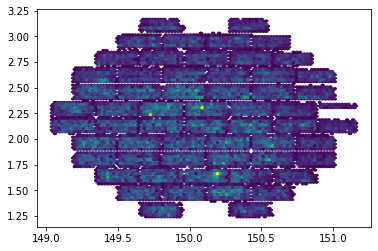

<Figure size 432x288 with 0 Axes>

In [47]:
plt.clf()
plt.hexbin(df_result.ra.values/7200.,df_result.dec.values/7200.,gridsize=100,mincnt=1)
plt.show()
plt.savefig(dir+"/RADEC-"+filename+".png")